To install rascal:
(NOTE: See the top-level README for the most up-to-date installation instructions.)
+ mkdir ../build 
+ cd build
+ cmake -DCMAKE_BUILD_TYPE=Release -DBUILD_TESTS=OFF ..
+ make -j 4
+ make install

In [1]:
!export OMP_NUM_THREADS=4
from mkl import set_num_threads
set_num_threads(4)

4

In [39]:
# %matplotlib inline
%matplotlib inline
from matplotlib import pylab as plt

import os, sys
sys.path.insert(0, './build/_deps/rascal-build/')
from ase.io import read

import sys
import time
import rascal
import json

import ase
from ase.io import read, write
from ase.build import make_supercell
from ase.visualize import view
import numpy as np
import sys
from tqdm.notebook import tqdm
#import nglview
import pandas as pd

import json

from rascal.representations import SphericalInvariants
from rascal.models import Kernel, train_gap_model, SparsePoints
from rascal.neighbourlist import AtomsList
from rascal.utils import from_dict, CURFilter, fps, BaseIO, to_dict
from rascal.utils.random_filter import RandomFilter
from rascal.utils.io import dump_obj,load_obj

In [3]:
sys.path.insert(0, './scripts/')
from utils.io import fromfile, tofile

# Utility functions

In [5]:
def extract_ref(frames,info_key='energy',array_key='forces'):
    y,f = [], []
    for frame in frames:
        y.append(frame.info[info_key])
        if array_key is None:
            pass
        elif array_key == 'zeros':
            f.append(np.zeros(frame.get_positions().shape))
        else:
            f.append(frame.get_array(array_key))
    y= np.array(y)
    try:
        f = np.concatenate(f)
    except:
        pass
    return y,f

In [6]:
from scipy.stats import spearmanr

def get_r2(y_pred,y_true):
    weight = 1
    sample_weight = None
    numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,dtype=np.float64)
    denominator = (weight * (y_true - np.average(
        y_true, axis=0, weights=sample_weight)) ** 2).sum(axis=0,dtype=np.float64)
    output_scores = 1 - (numerator / denominator)
    return np.mean(output_scores)

def get_mae(ypred,y):
    return np.mean(np.abs(ypred-y))
def get_rmse(ypred,y):
    return np.sqrt(np.mean((ypred-y)**2))
def get_sup(ypred,y):
    return np.amax(np.abs((ypred-y)))
def get_spearman(ypred,y):
    corr,_ = spearmanr(ypred,y)
    return corr

score_func = dict(
    MAE=get_mae,
    RMSE=get_rmse,
    SUP=get_sup,
    R2=get_r2,
    CORR=get_spearman
)

def get_score(ypred,y):
    scores = {}
    for k,func in score_func.items():
        scores[k] = func(ypred,y)
    return scores
def print_score(ypred,y):
    scores = get_score(ypred,y)
    print(' '.join(map(lambda x:'{}={:.2e}'.format(*x), scores.items())))


In [7]:
def link_ngl_wdgt_to_ax_pos(ax, pos, ngl_widget):
    from matplotlib.widgets import AxesWidget
    from scipy.spatial import cKDTree
    r"""
    Initial idea for this function comes from @arose, the rest is @gph82 and @clonker
    """
    
    kdtree = cKDTree(pos)        
    #assert ngl_widget.trajectory_0.n_frames == pos.shape[0]
    x, y = pos.T
    
    lineh = ax.axhline(ax.get_ybound()[0], c="black", ls='--')
    linev = ax.axvline(ax.get_xbound()[0], c="black", ls='--')
    dot, = ax.plot(pos[0,0],pos[0,1], 'o', c='red', ms=7)

    ngl_widget.isClick = False
    
    def onclick(event):
        linev.set_xdata((event.xdata, event.xdata))
        lineh.set_ydata((event.ydata, event.ydata))
        data = [event.xdata, event.ydata]
        _, index = kdtree.query(x=data, k=1)
        dot.set_xdata((x[index]))
        dot.set_ydata((y[index]))
        ngl_widget.isClick = True
        ngl_widget.frame = index
    
    def my_observer(change):
        r"""Here comes the code that you want to execute
        """
        ngl_widget.isClick = False
        _idx = change["new"]
        try:
            dot.set_xdata((x[_idx]))
            dot.set_ydata((y[_idx]))            
        except IndexError as e:
            dot.set_xdata((x[0]))
            dot.set_ydata((y[0]))
            print("caught index error with index %s (new=%s, old=%s)" % (_idx, change["new"], change["old"]))
    
    # Connect axes to widget
    axes_widget = AxesWidget(ax)
    axes_widget.connect_event('button_release_event', onclick)
    
    # Connect widget to axes
    ngl_widget.observe(my_observer, "frame", "change")
    
def view_ngl(frames):
    iwdg = nglview.show_asetraj(frames)
    # set up the visualization
    iwdg.add_unitcell()
    iwdg.add_spacefill()
    iwdg.remove_ball_and_stick()
    iwdg.camera = 'orthographic'
    iwdg.parameters = { "clipDist": 0 }
    iwdg.center()
    iwdg.update_spacefill(radiusType='covalent',
                                       scale=0.6,
                                       color_scheme='element')
    iwdg._remote_call('setSize', target='Widget',
                                   args=['%dpx' % (600,), '%dpx' % (400,)])
    iwdg.player.delay = 200.0
    return iwdg

def interactive_scatter(frames, pos):
    iwdg = view_ngl(frames)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
    link_ngl_wdgt_to_ax_pos(ax, pos, iwdg)
    ax.scatter(pos[:,0],pos[:,1],s=3)
    return fig, ax, iwdg

# dressed atom model

In [67]:
path = './structures/'
fns = {
    'qm9': path+'qm9.json',
    'molecular_crystals': path+'molecular_crystals.json',
    'silicon_bulk': path+'silicon_bulk.json',
    'methane_liquid': path+'methane_liquid.json',
    'methane_sulfonic': path+'methane_sulfonic.ubjson'
}
# en_field = {
#     'qm9': ,
#     'molecular_crystals': ,
#     'silicon_bulk': ,
#     'methane_liquid': ,
#     'methane_sulfonic': ,
# }
en_field = {
    'qm9': 'dHf_peratom',
    'molecular_crystals': 'ENERGY',
    'silicon_bulk': 'dft_energy',
    'methane_liquid': 'energy',
    'methane_sulfonic': 'energy',
}

In [71]:
fns = {
    'silicon_bulk': path+'silicon_bulk.json',
    'methane_liquid': path+'methane_liquid.json',
    'molecular_crystals': path+'molecular_crystals_100.json',
    'qm9': path+'qm9.json',
    'methane_sulfonic': path+'methane_sulfonic_150.json',
}

misc_entries = {
    'silicon_bulk' : {
        "N_ITERATIONS" : 20,
        'start_structure': 600,
        "n_structures" : 120,
        "n_replication" : 3,
    },
    'methane_liquid' : {
        "N_ITERATIONS" : 5,
        'start_structure': 100,
        "n_structures" : 100,
        "n_replication" : 2,
    },
    'methane_sulfonic' : {
        "N_ITERATIONS" : 5,
        'start_structure': 0,
        "n_structures" : 50,
        "n_replication" : 2,
    },
    'molecular_crystals' : {
        "N_ITERATIONS" : 5,
        'start_structure': 0,
        "n_structures" : 90,
        "n_replication" : 2,
    },
    'qm9' : {
        "N_ITERATIONS" : 5,
        'start_structure': 0,
        "n_structures" : 600,
        "n_replication" : 1,
    }
}

for name,fn in fns.items():
    st,lg = misc_entries[name]['start_structure'],misc_entries[name]['n_structures']
    frames = fromfile(fn)[st:st+lg]
    n_atoms = 0
    for f in frames:
        n_atoms += len(f)
    aa = [make_supercell(frames[0], misc_entries[name]['n_replication']*np.eye(3), wrap=True, tol=1e-11)]
    if name == 'qm9':
        aa = [[0],]*n_atoms
    print(name, n_atoms, len(aa[0]))

silicon_bulk 10186 1458
methane_liquid 13500 1080
molecular_crystals 13069 1408
qm9 10810 1
methane_sulfonic 14021 2184


10

In [10]:
numbers = []
for name,fn in fns.items():
    frames = fromfile(fn)
    # y ,_ = extract_ref(frames,info_key=en_field[name],array_key='zeros')
    
    for f in frames:
        numbers.extend(f.get_atomic_numbers())
np.unique(numbers)

array([ 1,  6,  7,  8,  9, 14, 16])

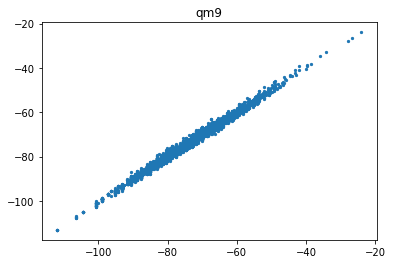

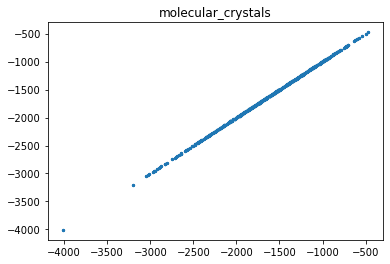

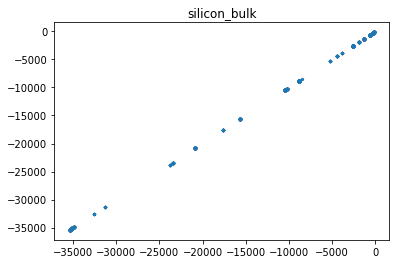

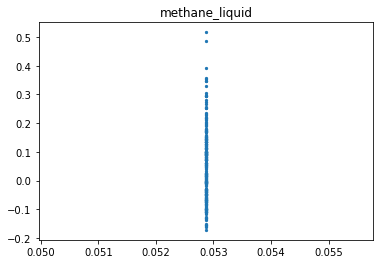

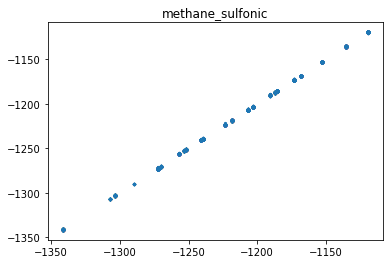

{'qm9': {1: -2.814211113635356, 6: -6.188222785018304, 7: -4.502686671958869, 8: -4.370847706508352, 9: -4.127123724359911}, 'molecular_crystals': {1: -1.2066278536666357, 6: -18.42141665763611, 7: -28.21055160856482, 8: -41.63852285569995}, 'silicon_bulk': {14: -162.98208752707743}, 'methane_liquid': {1: 0.0004607368691628243, 6: 0.00011518421729070611}, 'methane_sulfonic': {1: -0.6645519125911715, 6: -5.654232251386078, 8: -15.852522852103935, 16: -9.17258361289801}}


In [68]:
self_contributions = {}
for name,fn in fns.items():
    frames = fromfile(fn)
    y ,_ = extract_ref(frames,info_key=en_field[name],array_key='zeros')
    numbers = []
    for ii,f in enumerate(frames):
        numbers.append(np.bincount(f.get_atomic_numbers(), minlength=17))
        if name in ['qm9']:
            y[ii] *= len(f)
    numbers = np.array(numbers)
    x,residuals,rank,s = np.linalg.lstsq(numbers, y, rcond=None)
    ee = {ii:v for ii,v in enumerate(x) if np.abs(v) > 1e-14}
    self_contributions[name] = ee
    plt.scatter(np.dot(numbers, x), y, s=5)
    plt.title(name)
    plt.show()
print(self_contributions)

In [66]:
f.info

{'energy': -0.00790763,
 'iprint': 2,
 'task': 'SinglePoint',
 'calculate_stress': True,
 'calculate_hirshfeld': True,
 'backup_interval': 0,
 'write_bib': False,
 'opt_strategy': 'speed',
 'num_proc_in_smp': 12,
 'xc_functional': 'PBE0',
 'sedc_apply': False,
 'cut_off_energy': '700.0000000 eV',
 'finite_basis_corr': 0,
 'spin_polarized': False,
 'nextra_bands': 24,
 'elec_method': 'dm',
 'elec_energy_tol': '0.0000001 ev',
 'elec_force_tol': '0.0000010 ev/ang',
 'max_scf_cycles': 200,
 'fix_occupancy': True,
 'popn_calculate': False,
 'pdos_calculate_weights': False,
 'kpoints_mp_grid': [1, 1, 1],
 'castep_file_name': '280.castep',
 'castep_run_time': 20395.83,
 'virial': [[-686.03538733, -0.88171432, 4.33217939],
  [-0.88171432, -680.48074011, -1.35606383],
  [4.33217939, -1.35606383, -680.45631195]],
 'cutoff': -1.0,
 'nneightol': 1.2}

In [36]:
residuals

array([], dtype=float64)

In [45]:
!grep info -A 4 structures/methane_liquid.json

    "info": {
      "energy": 0.09720584,
      "iprint": 2,
      "task": "SinglePoint",
      "calculate_stress": true,
--
    "info": {
      "energy": 0.23643494,
      "iprint": 2,
      "task": "SinglePoint",
      "calculate_stress": true,
--
    "info": {
      "energy": -0.04888491,
      "iprint": 2,
      "task": "SinglePoint",
      "calculate_stress": true,
--
    "info": {
      "energy": 0.01020963,
      "iprint": 2,
      "task": "SinglePoint",
      "calculate_stress": true,
--
    "info": {
      "energy": -0.03261583,
      "iprint": 2,
      "task": "SinglePoint",
      "calculate_stress": true,
--
    "info": {
      "energy": -0.13402204,
      "iprint": 2,
      "task": "SinglePoint",
      "calculate_stress": true,
--
    "info": {
      "energy": 0.06182869,
      "iprint": 2,
      "task": "SinglePoint",
      "calculate_stress": true,
--
    "info": {
      "energy": 0.14482609,
      "iprint": 2,
      "task": "SinglePoint",
      "calculate_stress": true,


# Build a Force Field

In [72]:
# Total number of structure to load
N = 100
# Number of structure to train the model with
f = 60#int(0.9*N)

# load the structures
frames = read('./structures/qm9.json','600:{}'.format(600+N))

for ff in frames:
    ff.wrap(eps=1e-10)

global_species = []
for frame in frames:
    global_species.extend(frame.get_atomic_numbers())
global_species = np.unique(global_species)

# # split the structures in 2 sets
# ids = list(range(N))
# np.random.seed(10)
# np.random.shuffle(ids)

# frames_train = [frames[ii] for ii in ids[:f]]
# frames_test = [frames[ii] for ii in ids[f:]]

# Isolated atom contributions
self_contributions = {
    28:-1368.1846101788935,
}
global_species

array([1, 6, 7, 8, 9])

In [5]:
from ase.build import make_supercell

ImportError: cannot import name 'repeat' from 'ase.build' (/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/ase/build/__init__.py)

In [14]:
aa = make_supercell(frames[0], 2*np.eye(3), wrap=True, tol=1e-11)
len(aa)

432

In [15]:
0.19108644163546462 / 54 , 0.17428166861645877 / 54

(0.0035386378080641597, 0.0032274383077121995)

In [17]:
1.7814257099293171 / 432, 1.2361873626708983 / 432

(0.004123670624836383, 0.00286154482099745)

In [18]:
5.953633785434067 /1458, 3.317880967942377/1458

(0.0040834250928903065, 0.002275638523965965)

In [8]:
np.eye(3)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [73]:
interaction_cutoff = 4
nl_options = [
            dict(name='centers', args=[]),
            dict(name='neighbourlist', args=dict(cutoff=interaction_cutoff)),
            dict(name="centercontribution", args=dict()),
            dict(name='strict', args=dict(cutoff=interaction_cutoff))
        ]
managers = AtomsList(frames, nl_options)

In [74]:
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=interaction_cutoff, 
              max_radial=8, 
              max_angular=7, 
              gaussian_sigma_constant=0.3,
              gaussian_sigma_type="Constant",
              cutoff_smooth_width=0.5,
              normalize=True,
              radial_basis="GTO",
              compute_gradients=True,
              expansion_by_species_method='structure wise',
              optimization_args={
                  "type": "Spline", "accuracy": 1e-08, "range": [0, interaction_cutoff]
                },
              )
soap = SphericalInvariants(**hypers)
managers = soap.transform(managers)
managers.get_features(soap).shape

(1795, 7680)

In [75]:
8**2*8*5*6/2

7680.0

In [46]:
Nselect = 5
# compressor = RandomFilter(soap, Nselect, act_on='sample per species')
compressor = RandomFilter(soap, Nselect, act_on='feature')

X_pseudo = compressor.filter(managers)
hypers.update(**X_pseudo)
soap_f = SphericalInvariants(**hypers)

In [47]:
soap_f.transform(managers)

2.24 s ± 8.29 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [57]:
2.090851978764736 / 3388

0.0006171345864122598

In [10]:
# RMSE ~ 0.55 / 23 (energy/forces) on 10% of dataset in meV

In [11]:
y_train, f_train = extract_ref(frames_train,'energy','forces')
y_test, f_test = extract_ref(frames_test,'energy','forces')

KeyError: 'energy'

## utils

In [6]:
from rascal.utils import BaseIO

class KRR(BaseIO):
    """Kernel Ridge Regression model. Only compatible fully with sparse GPR
    training for the moment.

    Parameters
    ----------
    weights : np.array
        weights of the model

    kernel : Kernel
        kernel class used to train the model

    X_train : PseudoPoints
        reference samples used for the training

    self_contributions : dictionary
        map atomic number to the property baseline, e.g. isolated atoms
        energies when the model has been trained on total energies.
    """

    def __init__(self, weights, kernel, X_train, self_contributions):
        super(KRR, self).__init__()
        # Weights of the krr model
        self.weights = weights
        self.kernel = kernel
        self.X_train = X_train
        self.self_contributions = self_contributions
        self.target_type = kernel.target_type

    def _get_property_baseline(self, managers):
        """build total baseline contribution for each prediction"""
        if self.target_type == 'Structure':
            Y0 = np.zeros(len(managers))
            for i_manager, manager in enumerate(managers):
                numbers = manager.get_atomic_numbers()
                for sp in numbers:
                    Y0[i_manager] += self.self_contributions[sp]
        elif self.target_type == 'Atom':
            n_centers = 0
            for manager in managers:
                n_centers += len(manager)
            Y0 = np.zeros(n_centers)
            i_center = 0
            for manager in managers:
                for sp in manager.get_atomic_numbers():
                    Y0[i_center] = self.self_contributions[sp]
                    i_center += 1
        return Y0

    def _preprocess_input(self, managers, KNM, compute_gradients=False):
        """compute prediction kernel and total baseline contributions"""
        from rascal.utils.io import is_npy

        if KNM is not None: # if the KNM matrix is provided
            kernel = KNM
        else: # if the representation is provided
            kernel = self.kernel(managers, self.X_train, (compute_gradients, False))
        Y0 = self._get_property_baseline(managers)
        return kernel, Y0

    def predict(self, managers, KNM=None, compute_gradients=False):
        """Predict properties associated with the atomic structures in managers
        or their derivative w.r.t. atomic positions (if compute_gradients==True).

        Parameters
        ----------
        managers : AtomsList
            list of atomic structures with already computed features compatible
            with representation in kernel
        compute_gradients : bool, optional
            predict the gradients of the property w.r.t atomic positions,
            by default False

        Returns
        -------
        np.array
            predictions
        """
        KNM, Y0 = self._preprocess_input(managers, KNM, compute_gradients)
        if compute_gradients is False:
            return Y0 + np.dot(KNM, self.weights).reshape(-1)
        else:
            aa = np.dot(KNM, self.weights)
            print(aa.shape)
            return np.dot(KNM, self.weights).reshape(-1, 3)

    def get_weigths(self):
        return self.weights

    def get_init_params(self):
        init_params = dict(weights=self.weights, kernel=self.kernel,
                           X_train=self.X_train, self_contributions=self.self_contributions)
        return init_params

    def _set_data(self, data):
        pass

    def _get_data(self):
        return dict()

def train_gap_model(kernel, frames, KNM_, X_pseudo, y_train, self_contributions, grad_train=None, 
                    lambdas=None, jitter=1e-8):
    KMM = kernel(X_pseudo)
    Y = y_train.reshape((-1, 1)).copy()
    KNM = KNM_.copy()
    n_centers = Y.shape[0]
    Natoms = np.zeros(n_centers)
    Y0 = np.zeros((n_centers, 1))
    for iframe, frame in enumerate(frames):
        Natoms[iframe] = len(frame)
        numbers = frame.get_atomic_numbers()
        for sp in numbers:
            Y0[iframe] += self_contributions[sp]
    Y = Y - Y0
    delta = np.std(Y)
    print(delta)
    # lambdas[0] is provided per atom hence the '* np.sqrt(Natoms)'
    # the first n_centers rows of KNM are expected to refer to the
    # property
#     print(Natoms)
    KNM[:n_centers] /= lambdas[0] / delta * np.sqrt(Natoms)[:, None]
    Y /= lambdas[0] / delta * np.sqrt(Natoms)[:, None]

    if grad_train is not None:
        KNM[n_centers:] /= lambdas[1] / delta
        F = grad_train.reshape((-1, 1)).copy()
        F /= lambdas[1] / delta
        Y = np.vstack([Y, F])
    
    K = KMM + np.dot(KNM.T, KNM)
    eig,_ = np.linalg.eig(K)
#     print(eig.min())
    if eig.min() < 0:
        jitter = 1.05*abs(eig.min())
    else:
        jitter = 1e-9
#     print(jitter, eig.min())
    K[np.diag_indices_from(K)] += jitter
    
    Y = np.dot(KNM.T, Y)
    weights = np.linalg.solve(K, Y)
    model = KRR(weights, kernel, X_pseudo, self_contributions)
    
    # avoid memory clogging
    del K, KMM
    K, KMM = [], []

    return model

def train_gap_model_1(kernel, frames, KNM_, X_pseudo, self_contributions, grad_train, 
                    lambdas=None, jitter=1e-8):
    KMM = kernel(X_pseudo)
    n_centers = len(frames)
    KNM = KNM_[n_centers:].copy()
    
    
    KNM[n_centers:] /= lambdas[0] 
    F = grad_train.reshape((-1, 1)).copy()
    F /= lambdas[0]
    Y = F
    KMM[np.diag_indices_from(KMM)] += jitter
    
    K = KMM + np.dot(KNM.T, KNM)
    Y = np.dot(KNM.T, Y)
    weights = np.linalg.solve(K, Y)
    model = KRR(weights, kernel, X_pseudo, self_contributions)
    eig,_ = np.linalg.eig(K)
    print(eig.min())
    # avoid memory clogging
    del K, KMM
    K, KMM = [], []

    return model

def get_strides(frames):
    Nstructures = len(frames)
    Ngrad_stride = [0]
    Ngrads = 0
    for frame in frames:
        n_at = len(frame)
        Ngrad_stride.append(n_at*3)
        Ngrads += n_at*3
    Ngrad_stride = np.cumsum(Ngrad_stride) + Nstructures
    return Nstructures,Ngrads,Ngrad_stride

def _split_KNM(ids, frames, KNM, grad_strides):
    Nstruct, Ngrad, _ = get_strides(frames)
    KNM_ = np.zeros((Nstruct+Ngrad, KNM.shape[1]))
    i_struct,i_grad = 0, Nstruct
    for idx in ids:
        KNM_[i_struct] = KNM[idx]
        kk = KNM[grad_strides[idx]:grad_strides[idx+1]]
        KNM_[i_grad:i_grad+kk.shape[0]] = kk
        i_struct += 1
        i_grad += kk.shape[0]
    return KNM_

def split_data(frames,KNM,seed=10):
    Nstruct, Ngrad, grad_strides = get_strides(frames)
    ids = list(range(Nstruct))
    np.random.seed(seed)
    np.random.shuffle(ids)
    
    frames_train = [frames[ii] for ii in ids[:f]]
    frames_test = [frames[ii] for ii in ids[f:]]
    y_train, f_train = extract_ref(frames_train,'energy','forces')
    y_test, f_test = extract_ref(frames_test,'energy','forces')
    
    KNM_train = _split_KNM(ids[:f], frames_train, KNM, grad_strides)
    KNM_test = _split_KNM(ids[f:], frames_test, KNM, grad_strides)
    return (frames_train, y_train, f_train, KNM_train), (frames_test, y_test, f_test, KNM_test)

from concurrent.futures import as_completed, ProcessPoolExecutor

def compute(i_frame,frame):
        feat = soap.transform([frame])
        en_row = kernel(feat, X_pseudo)
        grad_rows = kernel(feat, X_pseudo, grad=(True, False))
        return en_row, grad_rows

def compute_KNM(frames,X_pseudo,kernel,soap):    
    Nstructures,Ngrads,Ngrad_stride = get_strides(frames)
    KNM = np.zeros((Nstructures+Ngrads, X_pseudo.size()))
    pbar = tqdm(frames,desc='kernel',leave=False)
    with ProcessPoolExecutor(max_workers=20) as executor:
        future_to_compute = {executor.submit(compute, i_frame, frame):i_frame
                                                     for i_frame,frame in enumerate(frames)}
        for future in as_completed(future_to_compute):
            i_frame = future_to_compute[future]
            en_row, grad_rows = future.result()
            KNM[i_frame] = en_row
            KNM[Ngrad_stride[i_frame]:Ngrad_stride[i_frame+1]] = grad_rows
            pbar.update()
    return KNM

## find some sparse points

In [18]:
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=5, 
              max_radial=10, 
              max_angular=12, 
              gaussian_sigma_constant=0.4,
              gaussian_sigma_type="Constant",
              cutoff_smooth_width=0.5,
              normalize=False,
              radial_basis="GTO",
              compute_gradients=False,
              expansion_by_species_method='structure wise',
              )
soap = SphericalInvariants(**hypers)

managers = soap.transform(frames)

In [19]:
managers.get_features(soap).shape

(100, 1300)

In [12]:
# Select pseudo input with CUR decomposition
Nselect = {1:50, 6:50}
Nselect = 30
# compressor = RandomFilter(soap, Nselect, act_on='sample per species')
compressor = RandomFilter(soap, Nselect, act_on='feature')

X_pseudo = compressor.filter(managers)
print(X_pseudo)
# del managers

{'coefficient_subselection': {'a': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 6, 6, 6, 6, 6, 6], 'b': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], 'n1': [0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 0, 0, 1, 1, 2, 2, 2], 'n2': [0, 1, 1, 2, 1, 2, 0, 0, 1, 2, 1, 2, 2, 0, 0, 1, 1, 2, 2, 0, 0, 1, 1, 1, 2, 0, 2, 0, 0, 1], 'l': [2, 0, 1, 0, 2, 2, 1, 2, 0, 2, 2, 1, 2, 1, 2, 0, 2, 1, 2, 1, 2, 0, 2, 1, 0, 2, 2, 0, 2, 2], 'selected_features_global_ids': [2, 3, 4, 6, 14, 17, 19, 20, 21, 26, 32, 34, 35, 37, 38, 39, 41, 43, 44, 46, 47, 48, 50, 58, 60, 65, 71, 72, 74, 77], 'selected_features_global_ids_fps_ordering': [14, 7, 18, 15, 26, 27, 9, 22, 6, 2, 3, 11, 4, 8, 24, 28, 0, 12, 10, 1, 29, 16, 20, 17, 19, 5, 25, 21, 13, 23]}}


In [44]:
X_pseudo.get_features().shape

(100, 2100)

In [48]:
!ls

build		environment.yml     query4plot_struc2rep.ipynb	src
build-reldbg	inputs		    README.md			structures
cmake		LICENSE		    results			Untitled.ipynb
CMakeLists.txt	MLIP_example.ipynb  scripts


In [49]:
!mkdir tests

In [50]:
dump_obj('./tests/sparse_points_radial_sp_rc5_n10_l0_g0.4_gto.json', X_pseudo)

## find some fps 

In [95]:
hypers = dict(soap_type="RadialSpectrum",
              interaction_cutoff=5, 
              max_radial=10, 
              max_angular=0, 
              gaussian_sigma_constant=0.4,
              gaussian_sigma_type="Constant",
              cutoff_smooth_width=0.5,
              normalize=False,
              radial_basis="GTO",
              compute_gradients=False,
              expansion_by_species_method='structure wise',
              )
soap = SphericalInvariants(**hypers)

managers = soap.transform(frames)

In [96]:
%%time
feature_matrix = managers.get_features(soap)
selection_dict = fps(feature_matrix, n_select=10000, starting_index=0, method='simple')

CPU times: user 37.3 s, sys: 158 ms, total: 37.5 s
Wall time: 37.2 s


<IPython.core.display.Javascript object>


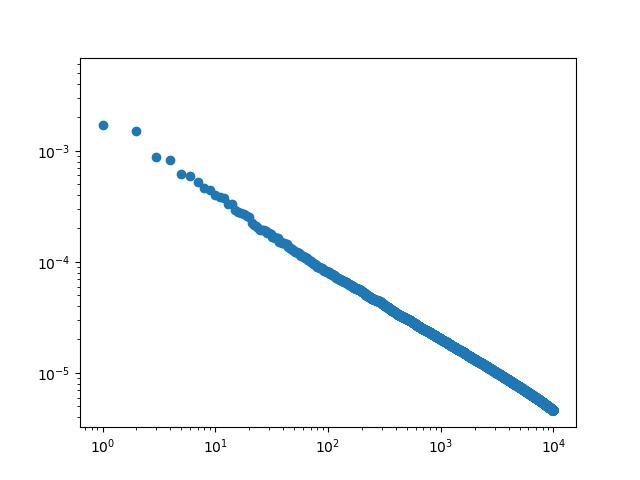

In [97]:
plt.plot(selection_dict['fps_minmax_d2'],'o')
plt.xscale('log')
plt.yscale('log')

In [98]:
strides_by_sp, global_counter, map_by_manager, indices_by_sp = compressor.get_index_mappings_sample_per_species(managers)

fps_ids = compressor.convert_selected_global_index2rascal_sample_per_species(
            managers, {28:np.sort(selection_dict['fps_indices'][:400])}, strides_by_sp, map_by_manager)

pseudo_points = PseudoPoints(soap)
pseudo_points.extend(managers, fps_ids)

dump_obj('../models/sparse_points_fps_radialspec_rc5_n10_l0_g0.4_gto_nonorm.json', pseudo_points)

## compute KNM

In [15]:
points_fn = '../models/sparse_points_fps_radialspec_rc5_n10_l0_g0.4_gto_nonorm.json'
KNM_fn = '../models/KNM_fps_radialspec_rc5_n10_l0_g0.4_gto_z1_nonorm.npy'
kernel_fn = '../models/kernel_fps_radialspec_rc5_n10_l0_g0.4_gto_z1_nonorm.json'
X_pseudo = load_obj(points_fn)


hypers = X_pseudo.representation.get_init_params()
hypers['compute_gradients'] = True
soap = SphericalInvariants(**hypers)
zeta = 1
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse')

KNM = compute_KNM(frames,X_pseudo,kernel,soap)
dump_obj(kernel_fn, kernel)
np.save(KNM_fn, KNM)

In [101]:
points_fn = '../models/sparse_points_rc5_n10_l6_g0.4_gto.json'
KNM_fn = '../models/KNM_rc5_n10_l6_g0.4_gto_z2.npy'
kernel_fn = '../models/kernel_rc5_n10_l6_g0.4_gto_z2.json'
X_pseudo = load_obj(points_fn)

hypers = X_pseudo.representation.get_init_params()
hypers['compute_gradients'] = True
soap = SphericalInvariants(**hypers)
zeta = 2
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse')

Nstructures = len(frames)
Ngrad_stride = [0]
Ngrads = 0
for frame in frames:
    n_at = len(frame)
    Ngrad_stride.append(n_at*3)
    Ngrads += n_at*3
Ngrad_stride = np.cumsum(Ngrad_stride) + Nstructures
dump_obj(kernel_fn, kernel)

In [102]:
from concurrent.futures import as_completed, ProcessPoolExecutor

def compute(i_frame,frame):
    feat = soap.transform([frame])
    en_row = kernel(feat, X_pseudo)
    grad_rows = kernel(feat, X_pseudo, grad=(True, False))
    return en_row, grad_rows

KNM = np.zeros((Nstructures+Ngrads, X_pseudo.size()))
pbar = tqdm(frames)
with ProcessPoolExecutor(max_workers=20) as executor:
    future_to_compute = {executor.submit(compute, i_frame, frame):i_frame
                                                 for i_frame,frame in enumerate(frames)}
    for future in as_completed(future_to_compute):
        i_frame = future_to_compute[future]
        en_row, grad_rows = future.result()
        KNM[i_frame] = en_row
        KNM[Ngrad_stride[i_frame]:Ngrad_stride[i_frame+1]] = grad_rows
        pbar.update()
print(KNM_fn)
np.save(KNM_fn, KNM)

In [91]:
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=8, 
              max_radial=12, 
              max_angular=8, 
              gaussian_sigma_constant=0.4,
              gaussian_sigma_type="Constant",
              cutoff_smooth_width=0.5,
              normalize=True,
              radial_basis="GTO",
              compute_gradients=True,
              expansion_by_species_method='structure wise',
              )
soap = SphericalInvariants(**hypers)
zeta = 1
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse')

In [92]:
Nstructures = len(frames)
Ngrad_stride = [0]
Ngrads = 0
for frame in frames:
    n_at = len(frame)
    Ngrad_stride.append(n_at*3)
    Ngrads += n_at*3
Ngrad_stride = np.cumsum(Ngrad_stride) + Nstructures


In [93]:
from concurrent.futures import as_completed, ProcessPoolExecutor

def compute(i_frame,frame):
    feat = soap.transform([frame])
    en_row = kernel(feat, X_pseudo)
    grad_rows = kernel(feat, X_pseudo, grad=(True, False))
    return en_row, grad_rows

KNM = np.zeros((Nstructures+Ngrads, X_pseudo.size()))
pbar = tqdm(frames)
with ProcessPoolExecutor(max_workers=20) as executor:
    future_to_compute = {executor.submit(compute, i_frame, frame):i_frame
                                                 for i_frame,frame in enumerate(frames)}
    for future in as_completed(future_to_compute):
        i_frame = future_to_compute[future]
        en_row, grad_rows = future.result()
        KNM[i_frame] = en_row
        KNM[Ngrad_stride[i_frame]:Ngrad_stride[i_frame+1]] = grad_rows
        pbar.update()

In [94]:
np.save('../models/KNM_rc8_n12_l8_g0.4_gto_z1.npy', KNM)

In [95]:
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=11, 
              max_radial=14, 
              max_angular=8, 
              gaussian_sigma_constant=0.4,
              gaussian_sigma_type="Constant",
              cutoff_smooth_width=0.5,
              normalize=True,
              radial_basis="GTO",
              compute_gradients=True,
              expansion_by_species_method='structure wise',
              )
soap = SphericalInvariants(**hypers)
zeta = 2
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse')

In [96]:
Nstructures = len(frames)
Ngrad_stride = [0]
Ngrads = 0
for frame in frames:
    n_at = len(frame)
    Ngrad_stride.append(n_at*3)
    Ngrads += n_at*3
Ngrad_stride = np.cumsum(Ngrad_stride) + Nstructures


In [97]:
from concurrent.futures import as_completed, ProcessPoolExecutor

def compute(i_frame,frame):
    feat = soap.transform([frame])
    en_row = kernel(feat, X_pseudo)
    grad_rows = kernel(feat, X_pseudo, grad=(True, False))
    return en_row, grad_rows

KNM = np.zeros((Nstructures+Ngrads, X_pseudo.size()))
pbar = tqdm(frames)
with ProcessPoolExecutor(max_workers=20) as executor:
    future_to_compute = {executor.submit(compute, i_frame, frame):i_frame
                                                 for i_frame,frame in enumerate(frames)}
    for future in as_completed(future_to_compute):
        i_frame = future_to_compute[future]
        en_row, grad_rows = future.result()
        KNM[i_frame] = en_row
        KNM[Ngrad_stride[i_frame]:Ngrad_stride[i_frame+1]] = grad_rows
        pbar.update()

In [98]:
np.save('../models/KNM_rc11_n14_l8_g0.4_gto_z2.json', KNM)

## train some models

In [299]:
!ls -lah ../models/

total 16G
drwxrwxrwx 2 musil COSMO-StaffU   13 Mär  3 17:35 .
drwxrwxrwx 6 musil COSMO-StaffU    6 Mär  3 15:47 ..
-rw-rw-rw- 1 musil COSMO-StaffU  43M Mär  3 15:57 gap_rc8_n12_l8_g0.4_gto_z2_lbd-1e-2-1e-3_jit1e-4.json
-rw-rw-rw- 1 musil COSMO-StaffU 1.1K Mär  3 12:13 kernel_rc11_n14_l8_g0.4_gto_z2.json
-rw-rw-rw- 1 musil COSMO-StaffU 1.1K Mär  3 12:13 kernel_rc8_n12_l8_g0.4_gto_z1.json
-rw-rw-rw- 1 musil COSMO-StaffU 1.1K Mär  3 12:12 kernel_rc8_n12_l8_g0.4_gto_z2.json
-rw-rw-rw- 1 musil COSMO-StaffU 4.2G Mär  3 02:39 KNM_rc11_n14_l8_g0.4_gto_z2.npy
-rw-rw-rw- 1 musil COSMO-StaffU 3.4G Mär  3 17:35 KNM_rc5_n10_l6_g0.4_gto_z2.json.npy
-rw-rw-rw- 1 musil COSMO-StaffU 4.2G Mär  2 22:52 KNM_rc8_n12_l8_g0.4_gto_z1.npy
-rw-rw-rw- 1 musil COSMO-StaffU 4.2G Mär  2 21:24 KNM_rc8_n12_l8_g0.4_gto_z2.npy
-rw-rw-rw- 1 musil COSMO-StaffU  54M Mär  3 12:49 sparse_points_rc11_n14_l8_g0.4_gto.json
-rw-rw-rw- 1 musil COSMO-StaffU  17M Mär  3 16:57 sparse_points_rc5_n10_l6_g0.4_gto.json
-rw-rw-rw- 1 mus

In [92]:
model_idx = 2

points_fns = {
    0:'../models/sparse_points_rc11_n14_l8_g0.4_gto.json',
    1:'../models/sparse_points_rc8_n12_l8_g0.4_gto.json',
    2:'../models/sparse_points_rc5_n10_l6_g0.4_gto.json',
}

knm_fns = {
    0:'../models/KNM_rc11_n14_l8_g0.4_gto_z2.npy',
    1:'../models/KNM_rc8_n12_l8_g0.4_gto_z2.npy',
    2:'../models/KNM_rc5_n10_l6_g0.4_gto_z2.npy',
}

kernel_fns = {
      0: '../models/kernel_rc11_n14_l8_g0.4_gto_z2.json',
      1: '../models/kernel_rc8_n12_l8_g0.4_gto_z2.json',
      2: '../models/kernel_rc5_n10_l6_g0.4_gto_z2.json',
}

X_pseudo = load_obj(points_fns[model_idx])
kernel = load_obj(kernel_fns[model_idx])

In [94]:
frames = read('../structures/replicated_input.xyz',':2200')
KNM = np.load(knm_fns[model_idx], mmap_mode='r')

In [95]:
(frames_train, y_train, f_train, KNM_train), (frames_test, 
                    y_test, f_test, KNM_test) = split_data(frames,KNM,seed=200)

In [96]:
model = train_gap_model(kernel, frames_train, KNM_train, X_pseudo, y_train, self_contributions, 
                        grad_train=-f_train, lambdas=[1e-3, 1e-2], jitter=2.7e-0)

16.919178264483474
(1.1683871044750478+0j)


In [97]:
# model = train_gap_model(kernel, frames_train, KNM_train[:len(frames_train)], X_pseudo, y_train, self_contributions, 
#                         grad_train=None, lambdas=[5e-4, 1e-2], jitter=3.2e-0)

In [98]:
# model = train_gap_model_1(kernel, frames_train, KNM_train, X_pseudo, self_contributions, -f_train, 
#                     lambdas=[1e-3], jitter=1e-4)

In [99]:
Ntest = len(frames_test)
y_pred = model.predict(frames_test, KNM_test[:Ntest])
f_pred = -model.predict(frames_test, KNM_test[Ntest:], compute_gradients=True)

(69468, 1)


In [100]:
Natoms = []
y_baseline = []
for frame in frames_test:
    Natoms.append(len(frame))
    y_baseline.append(len(frame)*self_contributions[28]) 
Natoms = np.array(Natoms).reshape(-1)   
y_baseline = np.array(y_baseline).reshape(-1)   

In [101]:
from scipy import stats
x = (y_pred-y_baseline)/Natoms
y = (y_test-y_baseline)/Natoms
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
intercept = 0

In [102]:
print_score((y_pred-y_baseline)/Natoms+intercept, (y_test-y_baseline)/Natoms)
print_score(f_pred.flatten(), f_test.flatten())
plt.plot((y_pred-y_baseline)/Natoms+intercept, (y_test-y_baseline)/Natoms, 'o')
# plt.plot(f_pred.flatten(), f_test.flatten(), 'o',ms=3)
plt.plot([-0.2,1.5],[-0.2,1.5])

MAE=1.16e-03 RMSE=4.49e-03 SUP=6.43e-02 R2=9.99e-01 CORR=1.00e+00
MAE=2.37e-02 RMSE=4.74e-02 SUP=1.12e+00 R2=9.96e-01 CORR=9.49e-01


In [63]:
print_score((y_pred-y_baseline)/Natoms, (y_test-y_baseline)/Natoms)
print_score(f_pred.flatten(), f_test.flatten())
plt.plot((y_pred-y_baseline)/Natoms, (y_test-y_baseline)/Natoms, 'o')
plt.plot([-0.2,1.5],[-0.2,1.5])
# plt.show()
# plt.plot(f_test[:,:].flatten(), f_pred[:,:].flatten(), 'o')

MAE=1.63e-02 RMSE=6.51e-02 SUP=8.74e-01 R2=8.16e-01 CORR=9.59e-01
MAE=6.59e+00 RMSE=1.11e+01 SUP=1.03e+02 R2=-2.33e+02 CORR=2.22e-01


In [76]:
Ntest = len(frames_train)
y_pred = model.predict(frames_train, KNM_train[:Ntest])
f_pred = -model.predict(frames_train, KNM_train[Ntest:], compute_gradients=True)

(627384, 1)


In [77]:
Natoms = []
y_baseline = []
for frame in frames_train:
    Natoms.append(len(frame))
    y_baseline.append(len(frame)*self_contributions[28]) 
Natoms = np.array(Natoms).reshape(-1)   
y_baseline = np.array(y_baseline).reshape(-1)   

<IPython.core.display.Javascript object>


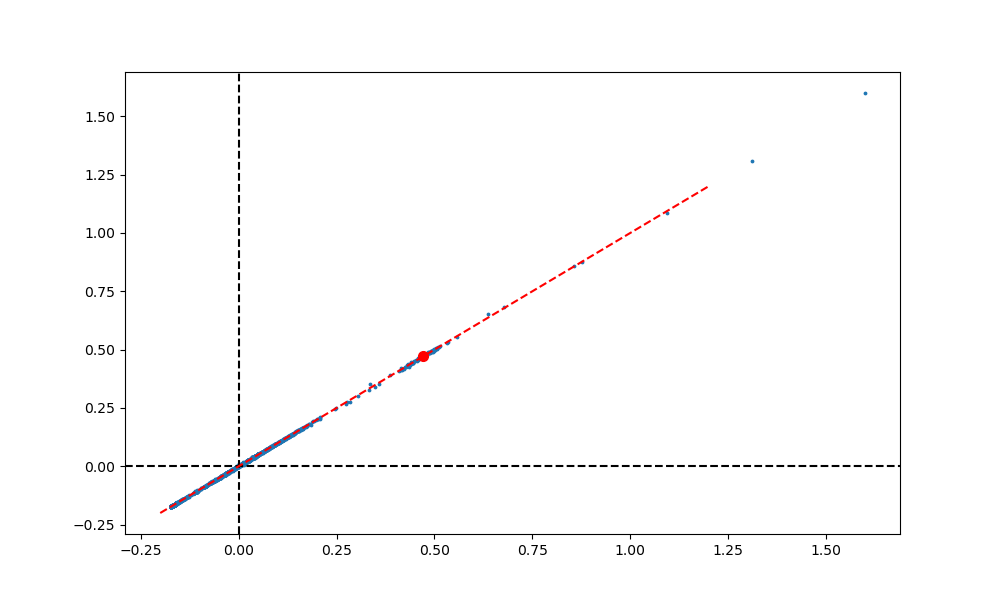

NGLWidget(max_frame=1979)

In [78]:
pos = np.hstack([((y_pred-y_baseline)/Natoms).reshape(-1,1), ((y_train-y_baseline)/Natoms).reshape(-1,1)])
_,ax,nglwg = interactive_scatter(frames_train, pos)
ax.plot([-0.2,1.2],[-0.2,1.2],'--r')
nglwg

In [170]:
print_score((y_pred-y_baseline)/Natoms, (y_train-y_baseline)/Natoms)
print_score(f_pred.flatten(), f_train.flatten())
# plt.plot((y_pred-y_baseline)/Natoms, (y_train-y_baseline)/Natoms, 'o')
# plt.plot([-0.1,0.6],[-0.1,0.6])
# plt.show()
# plt.plot(f_train[:,:].flatten(), f_pred[:,:].flatten(), 'o')

MAE=5.97e-03 RMSE=8.82e-03 SUP=4.25e-02 R2=9.97e-01 CORR=9.96e-01
MAE=2.18e-02 RMSE=4.97e-02 SUP=3.49e+00 R2=9.96e-01 CORR=9.58e-01


In [ ]:
lambdas=[1e-2, 1e-3], jitter=1e-4 kernel_rc8_n12_l8_g0.4_gto_z2

## train without some structures

In [103]:
model_idx = 2

points_fns = {
    0:'../models/sparse_points_rc11_n14_l8_g0.4_gto.json',
    1:'../models/sparse_points_rc8_n12_l8_g0.4_gto.json',
    2:'../models/sparse_points_rc5_n10_l6_g0.4_gto.json',
}

knm_fns = {
    0:'../models/KNM_rc11_n14_l8_g0.4_gto_z2.npy',
    1:'../models/KNM_rc8_n12_l8_g0.4_gto_z2.npy',
    2:'../models/KNM_rc5_n10_l6_g0.4_gto_z2.npy',
}

kernel_fns = {
      0: '../models/kernel_rc11_n14_l8_g0.4_gto_z2.json',
      1: '../models/kernel_rc8_n12_l8_g0.4_gto_z2.json',
      2: '../models/kernel_rc5_n10_l6_g0.4_gto_z2.json',
}

# knm_fns = ['../models/KNM_rc11_n14_l8_g0.4_gto_z2.npy',
#            '../models/KNM_rc8_n12_l8_g0.4_gto_z2.npy',
#            '../models/KNM_rc8_n12_l8_g0.4_gto_z1.npy']
# kernel_fns = [
#     '../models/kernel_rc11_n14_l8_g0.4_gto_z2.json',
#            '../models/kernel_rc8_n12_l8_g0.4_gto_z2.json',
#            '../models/kernel_rc8_n12_l8_g0.4_gto_z1.json'
# ]

X_pseudo = load_obj(points_fns[model_idx])
kernel = load_obj(kernel_fns[model_idx])
frames = read('../structures/replicated_input.xyz',':2200')
KNM = np.load(knm_fns[model_idx], mmap_mode='r')

In [112]:
y, f = extract_ref(frames,'energy','forces')
model = train_gap_model(kernel, frames, KNM, X_pseudo, y, self_contributions, 
                        grad_train=-f, lambdas=[1e-3, 1e-2], jitter=1.7e-0)

16.834378038600573
(-0.6801903028899492+0j)


In [113]:
Ntest = len(frames)
y_pred = model.predict(frames, KNM[:Ntest])
f_pred = -model.predict(frames, KNM[Ntest:], compute_gradients=True)

(696852, 1)


In [114]:
Natoms = []
y_baseline = []
for frame in frames:
    Natoms.append(len(frame))
    y_baseline.append(len(frame)*self_contributions[28]) 
Natoms = np.array(Natoms).reshape(-1)   
y_baseline = np.array(y_baseline).reshape(-1)   

In [115]:
print_score((y_pred-y_baseline)/Natoms, (y-y_baseline)/Natoms)
print_score(f_pred.flatten(), f.flatten())

MAE=1.12e-03 RMSE=1.66e-03 SUP=1.87e-02 R2=1.00e+00 CORR=1.00e+00
MAE=2.40e-02 RMSE=5.40e-02 SUP=4.02e+00 R2=9.95e-01 CORR=9.49e-01


<IPython.core.display.Javascript object>


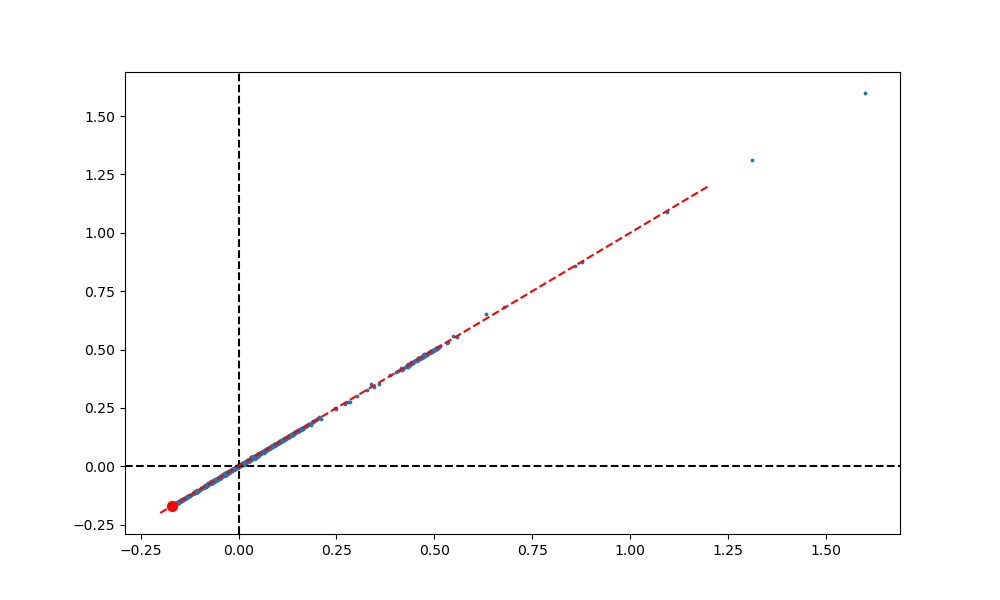

NGLWidget(max_frame=2199)

In [116]:
pos = np.hstack([((y_pred-y_baseline)/Natoms).reshape(-1,1), ((y-y_baseline)/Natoms).reshape(-1,1)])
_,ax,nglwg = interactive_scatter(frames, pos)
ax.plot([-0.2,1.2],[-0.2,1.2],'--r')
nglwg

In [180]:
view([frames[idx] for idx in [1071,504,1076,2128,1050,731,1805,745,413]])

In [187]:
view(frames[1029])

In [117]:
dump_obj('../models/gap_rc5_n10_l6_g0.4_gto_z2_lbd-1e-3-1e-2_jit1.7.json', model)

## train only energy

In [10]:
model_idx = 2

points_fns = {
    0:'../models/sparse_points_rc11_n14_l8_g0.4_gto.json',
    1:'../models/sparse_points_rc8_n12_l8_g0.4_gto.json',
    2:'../models/sparse_points_rc5_n10_l6_g0.4_gto.json',
}

knm_fns = {
    0:'../models/KNM_rc11_n14_l8_g0.4_gto_z2.npy',
    1:'../models/KNM_rc8_n12_l8_g0.4_gto_z2.npy',
    2:'../models/KNM_rc5_n10_l6_g0.4_gto_z2.npy',
}

kernel_fns = {
      0: '../models/kernel_rc11_n14_l8_g0.4_gto_z2.json',
      1: '../models/kernel_rc8_n12_l8_g0.4_gto_z2.json',
      2: '../models/kernel_rc5_n10_l6_g0.4_gto_z2.json',
}

# knm_fns = ['../models/KNM_rc11_n14_l8_g0.4_gto_z2.npy',
#            '../models/KNM_rc8_n12_l8_g0.4_gto_z2.npy',
#            '../models/KNM_rc8_n12_l8_g0.4_gto_z1.npy']
# kernel_fns = [
#     '../models/kernel_rc11_n14_l8_g0.4_gto_z2.json',
#            '../models/kernel_rc8_n12_l8_g0.4_gto_z2.json',
#            '../models/kernel_rc8_n12_l8_g0.4_gto_z1.json'
# ]

X_pseudo = load_obj(points_fns[model_idx])
kernel = load_obj(kernel_fns[model_idx])
frames = read('../structures/replicated_input.xyz',':2200')
KNM = np.load(knm_fns[model_idx], mmap_mode='r')

In [218]:
y, f = extract_ref(frames,'energy','forces')
model = train_gap_model(kernel, frames, KNM[:len(y)], X_pseudo, y, self_contributions, 
                        grad_train=None, lambdas=[1e-3, 1e-3], jitter=3e-1)

16.834378038600573
(0.0308599527562264+0j)


In [219]:
Ntest = len(frames)
y_pred = model.predict(frames, KNM[:Ntest])
f_pred = -model.predict(frames, KNM[Ntest:], compute_gradients=True)

(696852, 1)


In [220]:
Natoms = []
y_baseline = []
for frame in frames:
    Natoms.append(len(frame))
    y_baseline.append(len(frame)*self_contributions[28]) 
Natoms = np.array(Natoms).reshape(-1)   
y_baseline = np.array(y_baseline).reshape(-1)   

In [221]:
print_score((y_pred-y_baseline)/Natoms, (y-y_baseline)/Natoms)
print_score(f_pred.flatten(), f.flatten())

MAE=3.79e-04 RMSE=6.03e-04 SUP=6.76e-03 R2=1.00e+00 CORR=1.00e+00
MAE=3.97e-02 RMSE=8.54e-02 SUP=5.26e+00 R2=9.88e-01 CORR=9.07e-01


<IPython.core.display.Javascript object>


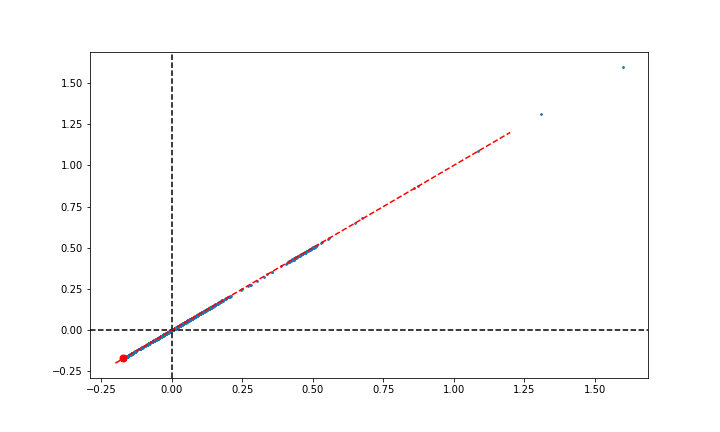

NGLWidget(max_frame=2199)

In [222]:
pos = np.hstack([((y_pred-y_baseline)/Natoms).reshape(-1,1), ((y-y_baseline)/Natoms).reshape(-1,1)])
_,ax,nglwg = interactive_scatter(frames, pos)
ax.plot([-0.2,1.2],[-0.2,1.2],'--r')
nglwg

In [21]:
(frames_train, y_train, f_train, KNM_train), (frames_test, 
                    y_test, f_test, KNM_test) = split_data(frames,KNM,seed=200)

In [27]:
model = train_gap_model(kernel, frames_train, KNM_train[:len(frames_train)], X_pseudo, y_train, self_contributions, 
                        grad_train=None, lambdas=[1e-3, 1e-3], jitter=3e-1)

16.919178264483474
(-0.027879189786483644+0j)


In [28]:
Ntest = len(frames_test)
y_pred = model.predict(frames_test, KNM_test[:Ntest])
f_pred = -model.predict(frames_test, KNM_test[Ntest:], compute_gradients=True)

(69468, 1)


In [29]:
Natoms = []
y_baseline = []
for frame in frames_test:
    Natoms.append(len(frame))
    y_baseline.append(len(frame)*self_contributions[28]) 
Natoms = np.array(Natoms).reshape(-1)   
y_baseline = np.array(y_baseline).reshape(-1)   

MAE=6.97e-04 RMSE=1.54e-03 SUP=1.23e-02 R2=1.00e+00 CORR=1.00e+00
MAE=4.11e-02 RMSE=8.32e-02 SUP=2.72e+00 R2=9.87e-01 CORR=9.13e-01


<IPython.core.display.Javascript object>


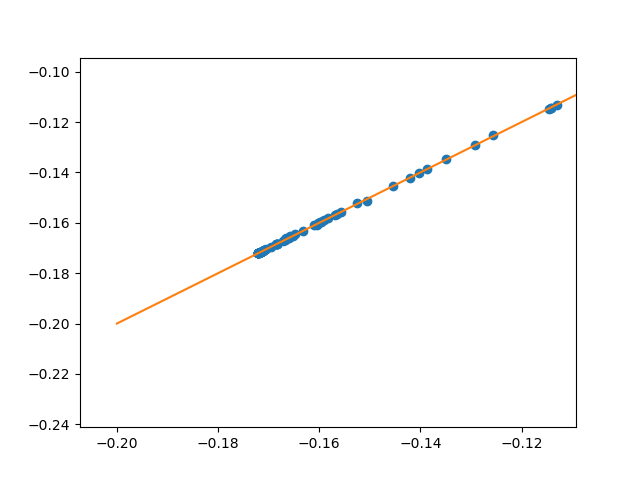

In [30]:
print_score((y_pred-y_baseline)/Natoms, (y_test-y_baseline)/Natoms)
print_score(f_pred.flatten(), f_test.flatten())
plt.plot((y_pred-y_baseline)/Natoms, (y_test-y_baseline)/Natoms, 'o')
plt.plot([-0.2,1.5],[-0.2,1.5])

MAE=6.31e-03 RMSE=9.27e-03 SUP=3.57e-02 R2=9.97e-01 CORR=9.94e-01
MAE=2.14e-02 RMSE=4.69e-02 SUP=2.26e+00 R2=9.96e-01 CORR=9.52e-01


## try radial and power spectrum

In [81]:
points_fns = [
    '../models/sparse_points_rc5_n10_l6_g0.4_gto.json',
    '../models/sparse_points_fps_radialspec_rc5_n10_l0_g0.4_gto_nonorm.json'
]

KNM_fns = [
    '../models/KNM_rc5_n10_l6_g0.4_gto_z2.npy',
    '../models/KNM_fps_radialspec_rc5_n10_l0_g0.4_gto_z1_nonorm.npy'
]

kernel_fns = [
    '../models/kernel_rc5_n10_l6_g0.4_gto_z2.json',
    '../models/kernel_fps_radialspec_rc5_n10_l0_g0.4_gto_z1_nonorm.json'
]

X_pseudo0 = load_obj(points_fns[1])
kernel0 = load_obj(kernel_fns[1])
KNM0 = np.load(KNM_fns[1], mmap_mode='r')

X_pseudo1 = load_obj(points_fns[0])
kernel1 = load_obj(kernel_fns[0])
KNM1 = np.load(KNM_fns[0], mmap_mode='r')

KNM = np.hstack([KNM0, KNM1])


In [85]:
frames = read('../structures/replicated_input.xyz',':2200')

In [88]:
def get_baseline(frames):
    Natoms = []
    y_baseline = []
    for frame in frames:
        Natoms.append(len(frame))
        y_baseline.append(len(frame)*self_contributions[28]) 
    Natoms = np.array(Natoms).reshape(-1)   
    y_baseline = np.array(y_baseline).reshape(-1)   
    return Natoms,y_baseline
def split_data(frames,KNM,spliter):
    Nstruct, Ngrad, grad_strides = get_strides(frames)
    ids = np.arange(Nstruct).reshape(-1,1)
    for train,test in spliter.split(ids):
        frames_train = [frames[ii] for ii in train]
        frames_test = [frames[ii] for ii in test]
        y_train, f_train = extract_ref(frames_train,'energy','forces')
        y_test, f_test = extract_ref(frames_test,'energy','forces')

        KNM_train = _split_KNM(train, frames_train, KNM, grad_strides)
        KNM_test = _split_KNM(test, frames_test, KNM, grad_strides)
        train_dict = dict(frames=frames_train, y=y_train, f=f_train, KNM=KNM_train)
        test_dict = dict(frames=frames_test, y=y_test, f=f_test, KNM=KNM_test)
        yield train_dict, test_dict

def train_gap_model(kernel, frames, KNM_, KMM_, X_pseudo, y_train, self_contributions, grad_train=None, 
                    lambdas=None, jitter=1e-8):
    KMM = KMM_.copy()
    Y = y_train.reshape((-1, 1)).copy()
    KNM = KNM_.copy()
    n_centers = Y.shape[0]
    Natoms = np.zeros(n_centers)
    Y0 = np.zeros((n_centers, 1))
    for iframe, frame in enumerate(frames):
        Natoms[iframe] = len(frame)
        numbers = frame.get_atomic_numbers()
        for sp in numbers:
            Y0[iframe] += self_contributions[sp]
    Y = Y - Y0
    delta = np.std(Y)
#     print(delta)
    # lambdas[0] is provided per atom hence the '* np.sqrt(Natoms)'
    # the first n_centers rows of KNM are expected to refer to the
    # property
#     print(Natoms)
    KNM[:n_centers] /= lambdas[0] / delta * np.sqrt(Natoms)[:, None]
    Y /= lambdas[0] / delta * np.sqrt(Natoms)[:, None]

    if grad_train is not None:
        KNM[n_centers:] /= lambdas[1] / delta
        F = grad_train.reshape((-1, 1)).copy()
        F /= lambdas[1] / delta
        Y = np.vstack([Y, F])

    KMM[np.diag_indices_from(KMM)] += jitter
    
    K = KMM + np.dot(KNM.T, KNM)
    Y = np.dot(KNM.T, Y)
    weights = np.linalg.solve(K, Y)
    model = KRR(weights, kernel, X_pseudo, self_contributions)
    eig,_ = np.linalg.eig(K)
    print(eig.min())
    # avoid memory clogging
    del K, KMM
    K, KMM = [], []

    return model


In [117]:
from sklearn.model_selection._split import KFold,ShuffleSplit
import pandas as pd

N0 = X_pseudo0.size()
N1 = X_pseudo1.size()
N = N1+N0
KMM = np.zeros((N,N))
jitter = 0.02
KMM[:N0,:N0] = kernel0(X_pseudo0) + .5*np.eye(N0)
KMM[N0:N,N0:N] = kernel1(X_pseudo1) + 0.02*np.eye(N1)


# spliter = KFold(n_splits=10, shuffle=True, random_state=100)
spliter = ShuffleSplit(n_splits=1, random_state=100)
scores_e,scores_f = [], []
for train, test in split_data(frames, KNM, spliter):
    model = train_gap_model(kernel, train['frames'], train['KNM'],KMM, X_pseudo, train['y'], self_contributions, 
                        grad_train=-train['f'], lambdas=[1e-2, 10e-1], jitter=0.0)
    
    Natoms,y_baseline = get_baseline(test['frames'])
    Ntest = len(test['frames'])
    y_pred = model.predict(test['frames'], test['KNM'][:Ntest])
    f_pred = -model.predict(test['frames'], test['KNM'][Ntest:], compute_gradients=True)
    score_e = get_score((y_pred-y_baseline)/Natoms, (test['y']-y_baseline)/Natoms)
    score_f = get_score(f_pred.flatten(), test['f'].flatten())
    scores_e.append(score_e)
    scores_f.append(score_f)
scores_e = pd.DataFrame(scores_e)
scores_f = pd.DataFrame(scores_f)
# print_score((y_pred-y_baseline)/Natoms, (y_train-y_baseline)/Natoms)
# print_score(f_pred.flatten(), f_train.flatten())
print(scores_e)
print(scores_f)

(0.004533522892722968+0j)
(69525, 1)
        MAE      RMSE       SUP        R2      CORR
0  0.000611  0.001569  0.017078  0.999909  0.999824
       MAE      RMSE       SUP        R2      CORR
0  0.02529  0.056743  2.893937  0.992823  0.944157


In [134]:
aa = scores_e.mean(axis=0)
bb = scores_f.mean(axis=0)
ee = pd.DataFrame([aa,bb],index=['Energy [eV]','Forces [eV/A]'])
ee

,MAE,RMSE,SUP,R2,CORR
Energy [eV],0.000611,0.001569,0.017078,0.999909,0.999824
Forces [eV/A],0.025290,0.056743,2.893937,0.992823,0.944157


In [75]:
from sklearn.model_selection._split import KFold,ShuffleSplit
import pandas as pd
# spliter = KFold(n_splits=10, shuffle=True, random_state=100)
spliter = ShuffleSplit(n_splits=1, random_state=100)
scores_e,scores_f = [], []
models = []
for train, test in split_data_2(frames, KNM0, KNM1, spliter):
    model = train_gap_model(kernel, train['frames'], train['KNM0'], X_pseudo0, train['y'], self_contributions, 
                        grad_train=-train['f'], lambdas=[5e-3, 5e-2], jitter=1e-1)
    
    Natoms,y_baseline = get_baseline(train['frames'])
    Ntest = len(train['frames'])
    y_pred = model.predict(train['frames'], train['KNM0'][:Ntest])
    f_pred = -model.predict(train['frames'], train['KNM0'][Ntest:], compute_gradients=True)
    print_score((y_pred-y_baseline)/Natoms, (train['y']-y_baseline)/Natoms)
    models.append(model)

    model = train_gap_model(kernel, train['frames'], train['KNM1'], X_pseudo1, train['y']-y_pred , 
                        self_contributions,  grad_train=-(train['f']-f_pred), lambdas=[1e-2, 1e-1], jitter=0.1)
    models.append(model)
    
    Natoms,y_baseline = get_baseline(test['frames'])
    Ntest = len(test['frames'])
    y_pred = np.zeros_like(test['y'])
    f_pred = np.zeros_like(test['f'])
    for ii,model in enumerate(models):
        y_pred += model.predict(test['frames'], test[f'KNM{ii}'][:Ntest])
        f_pred += -model.predict(test['frames'], test[f'KNM{ii}'][Ntest:], compute_gradients=True)
    score_e = get_score((y_pred-y_baseline)/Natoms, (test['y']-y_baseline)/Natoms)
    score_f = get_score(f_pred.flatten(), test['f'].flatten())
    scores_e.append(score_e)
    scores_f.append(score_f)
scores_e = pd.DataFrame(scores_e)
scores_f = pd.DataFrame(scores_f)
# print_score((y_pred-y_baseline)/Natoms, (y_train-y_baseline)/Natoms)
# print_score(f_pred.flatten(), f_train.flatten())
print(scores_e)
print(scores_f)

16.76757210100776
(0.09999169903868343-1.3099795441633735e-07j)
(627327, 1)
MAE=1.39e-02 RMSE=2.87e-02 SUP=6.59e-01 R2=9.67e-01 CORR=9.82e-01
7673.850695650241
(-2871.64493354495+0j)
(69525, 1)
(69525, 1)
        MAE      RMSE         SUP           R2      CORR
0  1.471138  7.314395  101.078362 -1981.228519  0.113509
         MAE      RMSE         SUP           R2      CORR
0  18.411657  36.82805  636.995647 -3022.265881  0.020859


## try out radial scaling

In [36]:
from itertools import product
scales = [1,2,3,4,5]
exponents = [1,2,3,4,5,6]
zetas = [2]
lambdas = [[1e-3, 1e-2],[5e-3, 1e-2],[1e-3, 5e-2],[5e-3, 5e-2],[1e-3, 1e-2],[10e-3, 10e-2],
           [5e-4, 1e-2], ]
fn_prefix = '../models/radial_scaling/'
selected_ids_fn_tmp = fn_prefix+'sparse_points_ids_rc{}_n{}_l{}_g{:.1f}_gto.npy'
sparsepoint_fn_tmp = fn_prefix+'sparse_points_rc{}_n{}_l{}_g{:.1f}_gto_r0{}_exp{}.json'
KNM_fn_tmp = fn_prefix+'KNM_rc{}_n{}_l{}_g{:.1f}_gto_r0{}_exp{}_z{}.npy'
kernel_fn_tmp = fn_prefix+'kernel_rc{}_n{}_l{}_g{:.1f}_gto_r0{}_exp{}_z{}.json'
model_fn_tmp = fn_prefix+'model_rc{}_n{}_l{}_g{:.1f}_gto_r0{}_exp{}_z{}_lmbe{:.0e}_lmbf{:.0e}.json'

In [10]:
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=6, 
              max_radial=12, 
              max_angular=7, 
              gaussian_sigma_constant=0.4,
              cutoff_function_type='RadialScaling',
              gaussian_sigma_type="Constant",
              cutoff_smooth_width=0.5,
              normalize=True,
              radial_basis="GTO",
              optimization_args=dict(type="Spline", accuracy=1e-8),
              compute_gradients=False,
              expansion_by_species_method='structure wise',
              )

In [17]:
def get_baseline(frames):
    Natoms = []
    y_baseline = []
    for frame in frames:
        Natoms.append(len(frame))
        y_baseline.append(len(frame)*self_contributions[28]) 
    Natoms = np.array(Natoms).reshape(-1)   
    y_baseline = np.array(y_baseline).reshape(-1)   
    return Natoms,y_baseline

def split_data(frames,KNM,spliter):
    Nstruct, Ngrad, grad_strides = get_strides(frames)
    ids = np.arange(Nstruct).reshape(-1,1)
    for train,test in spliter.split(ids):
        frames_train = [frames[ii] for ii in train]
        frames_test = [frames[ii] for ii in test]
        y_train, f_train = extract_ref(frames_train,'energy','forces')
        y_test, f_test = extract_ref(frames_test,'energy','forces')

        KNM_train = _split_KNM(train, frames_train, KNM, grad_strides)
        KNM_test = _split_KNM(test, frames_test, KNM, grad_strides)
        train_dict = dict(frames=frames_train, y=y_train, f=f_train, KNM=KNM_train)
        test_dict = dict(frames=frames_test, y=y_test, f=f_test, KNM=KNM_test)
        yield train_dict, test_dict


### find sparse points indices

In [26]:
from rascal.utils.cur import do_CUR
from rascal.models import PseudoPoints
from scipy.sparse.linalg import svds

class CURFilter(object):
    """CUR decomposition to select samples or features in a given feature matrix. Wrapper around the do_CUR function for convenience.

    Parameters
    ----------
    representation : Calculator
        Representation calculator associated with the kernel

    Nselect: int
        number of points to select. if act_on='sample per specie' then it should
        be a dictionary mapping atom type to the number of samples, e.g.
        Nselect = {1:200,6:100,8:50}.

    act_on: string
        Select how to apply the selection. Can be either of 'sample',
        'sample per species','feature'.
        For the moment only 'sample per specie' is implemented.

    is_deterministic: bool
        flag to switch between selction criteria

    seed: int
        if is_deterministic==False, seed for the random selection

    """

    def __init__(self, representation, Nselect, act_on='sample per specie', is_deterministic=True, seed=10):
        super(CURFilter, self).__init__()
        self._representation = representation
        self.Nselect = Nselect
        if act_on in ['sample', 'sample per specie', 'feature']:
            self.act_on = act_on
        else:
            raise 'Wrong input: {}'.format(act_on)
        self.is_deterministic = is_deterministic
        self.seed = seed
        self.selected_ids = None
    
    def transform(self, managers):
        # build the pseudo points
        pseudo_points = PseudoPoints(self._representation)
        pseudo_points.extend(managers, self.selected_ids)

        return pseudo_points
    
    def fit(self, managers):
        if self.act_on in ['sample per specie']:
            # get the dense feature matrix
            X = managers.get_features(self._representation)

            sps = list(self.Nselect.keys())

            # get various info from the structures about the center atom species and indexing
            (strides_by_sp, global_counter, map_by_manager,
             indices_by_sp) = self.get_index_mappings_sample_per_species(managers)

            print('The number of pseudo points selected by central atom species is: {}'.format(
                self.Nselect))

            # organize features w.r.t. central atom type
            X_by_sp = {}
            for sp in sps:
                X_by_sp[sp] = X[indices_by_sp[sp]]
            self._XX = X_by_sp

            # split the dense feature matrix by center species and apply CUR decomposition
            selected_ids_by_sp = {}
            for sp in sps:
                print('Selecting species: {}'.format(sp))
                selected_ids_by_sp[sp] = np.sort(do_CUR(X_by_sp[sp], self.Nselect[sp], self.act_on,
                                                        self.is_deterministic, self.seed))

            self.selected_ids = self.convert_selected_global_index2rascal_sample_per_species(
                managers, selected_ids_by_sp, strides_by_sp, map_by_manager)
        else:
            raise NotImplementedError("method: {}".format(self.act_on))
        
        return self
            
    def fit_transform(self, managers):
        """Perform CUR selection of samples/features.

        Parameters
        ----------
        managers : AtomsList
            list of structures containing features computed with representation

        Returns
        -------
        PseudoPoints
            Selected samples

        Raises
        ------
        ValueError
            [description]
        NotImplementedError
            [description]
        """


        return self.fit(managers).transform(managers)
        
    def get_index_mappings_sample_per_species(self, managers):
        # get various info from the structures about the center atom species and indexing
        sps = list(self.Nselect.keys())
        types = []
        strides_by_sp = {sp: [0] for sp in sps}
        global_counter = {sp: 0 for sp in sps}
        indices_by_sp = {sp: [] for sp in sps}
        map_by_manager = [{} for ii in range(len(managers))]
        for i_man, man in enumerate(managers):
            counter = {sp: 0 for sp in sps}
            for i_at, at in enumerate(man):
                types.append(at.atom_type)
                if at.atom_type in sps:
                    map_by_manager[i_man][global_counter[at.atom_type]] = i_at
                    counter[at.atom_type] += 1
                    global_counter[at.atom_type] += 1
                else:
                    raise ValueError('Atom type {} has not been specified in fselect: {}'.format(
                        at.atom_type, self.Nselect))
            for sp in sps:
                strides_by_sp[sp].append(counter[sp])

        for sp in sps:
            strides_by_sp[sp] = np.cumsum(strides_by_sp[sp])

        for ii, sp in enumerate(types):
            indices_by_sp[sp].append(ii)

        return strides_by_sp, global_counter, map_by_manager, indices_by_sp

    def convert_selected_global_index2rascal_sample_per_species(self, managers, selected_ids_by_sp, strides_by_sp, map_by_manager):
        # convert selected center indexing into the rascal format
        selected_ids = [[] for ii in range(len(managers))]
        sps = list(self.Nselect.keys())
        i_manager = {sp: 0 for sp in sps}
        for sp in sps:
            for idx in selected_ids_by_sp[sp]:
                carry_on = True
                while carry_on:
                    if idx >= strides_by_sp[sp][i_manager[sp]] and idx < strides_by_sp[sp][i_manager[sp] + 1]:
                        selected_ids[i_manager[sp]].append(
                            map_by_manager[i_manager[sp]][idx])
                        carry_on = False
                    else:
                        i_manager[sp] += 1
        for ii in range(len(selected_ids)):
            selected_ids[ii] = list(np.sort(selected_ids[ii]))
        return selected_ids

In [27]:
%%time
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=6, 
              max_radial=12, 
              max_angular=7, 
              gaussian_sigma_constant=0.4,
#               cutoff_function_type='RadialScaling',
#               cutoff_function_parameters=dict(rate=1,scale=3,exponent=3),
              gaussian_sigma_type="Constant",
              cutoff_smooth_width=0.5,
              normalize=True,
              radial_basis="GTO",
              optimization_args=dict(type="Spline", accuracy=1e-8),
              compute_gradients=False,
              expansion_by_species_method='structure wise',
              )
soap = SphericalInvariants(**hypers)

managers = soap.transform(frames)

CPU times: user 1min 1s, sys: 3.84 s, total: 1min 5s
Wall time: 1min 5s


In [28]:
aa = managers.get_features(soap)
aa.shape

(232284, 1152)

In [29]:
%%time
# Select pseudo input with CUR decomposition
n_pseudo = {28:400}

compressor = CURFilter(soap, n_pseudo, act_on='sample per specie')

compressor.fit(managers)
selected_ids = compressor.selected_ids
del managers
selected_ids

The number of pseudo points selected by central atom species is: {28: 400}
Selecting species: 28
Reconstruction RMSE=2.014e-01
CPU times: user 37min 52s, sys: 35.4 s, total: 38min 28s
Wall time: 2min 42s


[[],
 [],
 [],
 [6, 18, 34],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [28, 46, 50, 57, 99, 103, 105],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [46],
 [],
 [],
 [12, 16, 97],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [19, 35, 48, 92],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [2, 56, 67, 83],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [23, 30, 66, 67, 90, 97],
 [],
 [],
 [],
 [41, 42, 43, 107],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [11, 20, 22

In [34]:
selected_ids_fn = '../models/radial_scaling/sparse_points_ids_rc6_n12_l7_g0.4_gto.npy'
np.save(selected_ids_fn, selected_ids)

In [39]:
aa = list(np.load(selected_ids_fn, allow_pickle=True))

[[],
 [],
 [],
 [6, 18, 34],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [28, 46, 50, 57, 99, 103, 105],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [46],
 [],
 [],
 [12, 16, 97],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [19, 35, 48, 92],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [2, 56, 67, 83],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [23, 30, 66, 67, 90, 97],
 [],
 [],
 [],
 [41, 42, 43, 107],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [11, 20, 22

### compute the sparse points

In [55]:
for (scale, exponent) in tqdm(product(scales, exponents),total=len(list(product(scales, exponents)))):
    hypers['cutoff_function_parameters'] = dict(rate=1,scale=scale,exponent=exponent)
    soap = SphericalInvariants(**hypers)

    managers = soap.transform(frames)

    n_pseudo = {28:400}

    selected_ids_fn = selected_ids_fn_tmp.format(hypers['interaction_cutoff'],
                                                            hypers['max_radial'],
                                                            hypers['max_angular'],
                                                            hypers['gaussian_sigma_constant'],)
    sparsepoint_fn = sparsepoint_fn_tmp.format(hypers['interaction_cutoff'],
                                                hypers['max_radial'],
                                                hypers['max_angular'],
                                                hypers['gaussian_sigma_constant'],
                                                scale,exponent,)
    print(selected_ids_fn, sparsepoint_fn)
    compressor = CURFilter(soap, n_pseudo, act_on='sample per specie')
    compressor.selected_ids = list(np.load(selected_ids_fn, allow_pickle=True))

    X_pseudo = compressor.transform(managers)

    dump_obj(sparsepoint_fn, X_pseudo)

../models/radial_scaling/sparse_points_ids_rc6_n12_l7_g0.4_gto.npy ../models/radial_scaling/sparse_points_rc6_n12_l7_g0.4_gto_r01_exp1.json
../models/radial_scaling/sparse_points_ids_rc6_n12_l7_g0.4_gto.npy ../models/radial_scaling/sparse_points_rc6_n12_l7_g0.4_gto_r01_exp2.json
../models/radial_scaling/sparse_points_ids_rc6_n12_l7_g0.4_gto.npy ../models/radial_scaling/sparse_points_rc6_n12_l7_g0.4_gto_r01_exp3.json
../models/radial_scaling/sparse_points_ids_rc6_n12_l7_g0.4_gto.npy ../models/radial_scaling/sparse_points_rc6_n12_l7_g0.4_gto_r01_exp4.json
../models/radial_scaling/sparse_points_ids_rc6_n12_l7_g0.4_gto.npy ../models/radial_scaling/sparse_points_rc6_n12_l7_g0.4_gto_r01_exp5.json
../models/radial_scaling/sparse_points_ids_rc6_n12_l7_g0.4_gto.npy ../models/radial_scaling/sparse_points_rc6_n12_l7_g0.4_gto_r01_exp6.json



### compute KNMs

In [17]:
for (scale, exponent, zeta) in tqdm(product(scales, exponents, zetas),
                                    total=len(list(product(scales, exponents, zetas)))):
    sparsepoint_fn = sparsepoint_fn_tmp.format(hypers['interaction_cutoff'],
                                                hypers['max_radial'],
                                                hypers['max_angular'],
                                                hypers['gaussian_sigma_constant'],
                                                scale,exponent)
    KNM_fn = KNM_fn_tmp.format(hypers['interaction_cutoff'],
                                                hypers['max_radial'],
                                                hypers['max_angular'],
                                                hypers['gaussian_sigma_constant'],
                                                scale,exponent,zeta)
    kernel_fn = kernel_fn_tmp.format(hypers['interaction_cutoff'],
                                                hypers['max_radial'],
                                                hypers['max_angular'],
                                                hypers['gaussian_sigma_constant'],
                                                scale,exponent,zeta)
    
    X_pseudo = load_obj(sparsepoint_fn)

    hypers = X_pseudo.representation.get_init_params()
    hypers['compute_gradients'] = True
    soap = SphericalInvariants(**hypers)
    
    kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse')

    KNM = compute_KNM(frames,X_pseudo,kernel,soap)
    
    dump_obj(kernel_fn, kernel)
    np.save(KNM_fn,KNM)

### Eval models

In [18]:
from sklearn.model_selection._split import KFold, ShuffleSplit

spliter = KFold(n_splits=10, shuffle=True, random_state=100)
# spliter = ShuffleSplit(n_splits=1, random_state=100)
scores_e_all = []
scores_f_all = []
for (scale, exponent, zeta, lambdas_) in tqdm(product(scales, exponents, zetas, lambdas),
                                    total=len(list(product(scales, exponents, zetas, lambdas)))):
    sparsepoint_fn = sparsepoint_fn_tmp.format(hypers['interaction_cutoff'],
                                                hypers['max_radial'],
                                                hypers['max_angular'],
                                                hypers['gaussian_sigma_constant'],
                                                scale,exponent)
    KNM_fn = KNM_fn_tmp.format(hypers['interaction_cutoff'],
                                                hypers['max_radial'],
                                                hypers['max_angular'],
                                                hypers['gaussian_sigma_constant'],
                                                scale,exponent,zeta)
    kernel_fn = kernel_fn_tmp.format(hypers['interaction_cutoff'],
                                                hypers['max_radial'],
                                                hypers['max_angular'],
                                                hypers['gaussian_sigma_constant'],
                                                scale,exponent,zeta)
    
    X_pseudo = load_obj(sparsepoint_fn)
    KNM = np.load(KNM_fn, mmap_mode='r')
    kernel = load_obj(kernel_fn)
    scores_e,scores_f = [], []
    for train, test in split_data(frames, KNM, spliter):
        model = train_gap_model(kernel, train['frames'], train['KNM'], X_pseudo, train['y'], self_contributions, 
                            grad_train=-train['f'], lambdas=lambdas_, jitter=1e-1)

        Natoms,y_baseline = get_baseline(test['frames'])
        Ntest = len(test['frames'])
        y_pred = model.predict(test['frames'], test['KNM'][:Ntest])
        f_pred = -model.predict(test['frames'], test['KNM'][Ntest:], compute_gradients=True)
        score_e = get_score((y_pred-y_baseline)/Natoms, (test['y']-y_baseline)/Natoms)
        score_f = get_score(f_pred.flatten(), test['f'].flatten())
        score_e.update(scale=scale, exponent=exponent, zeta=zeta,lambda_e = lambdas_[0],lambda_f = lambdas_[1])
        score_f.update(scale=scale, exponent=exponent, zeta=zeta,lambda_e = lambdas_[0],lambda_f = lambdas_[1])
        scores_e.append(score_e)
        scores_f.append(score_f)
    
    scores_e_all.append(pd.DataFrame(scores_e).mean(axis=0))
    scores_f_all.append(pd.DataFrame(scores_f).mean(axis=0))
    

16.76757210100776
(69525, 1)
16.999987311336913
(69708, 1)
16.89760179428629
(69447, 1)
16.956735522430254
(69651, 1)
16.97357707450273
(70362, 1)
16.83729650556299
(69768, 1)
16.52869467855449
(69303, 1)
16.912180404890098
(69882, 1)
16.93435532206938
(69330, 1)
16.525350043084366
(69876, 1)
16.76757210100776
(69525, 1)
16.999987311336913
(69708, 1)
16.89760179428629
(69447, 1)
16.956735522430254
(69651, 1)
16.97357707450273
(70362, 1)
16.83729650556299
(69768, 1)
16.52869467855449
(69303, 1)
16.912180404890098
(69882, 1)
16.93435532206938
(69330, 1)
16.525350043084366
(69876, 1)
16.76757210100776
(69525, 1)
16.999987311336913
(69708, 1)
16.89760179428629
(69447, 1)
16.956735522430254
(69651, 1)
16.97357707450273
(70362, 1)
16.83729650556299
(69768, 1)
16.52869467855449
(69303, 1)
16.912180404890098
(69882, 1)
16.93435532206938
(69330, 1)
16.525350043084366
(69876, 1)
16.76757210100776
(69525, 1)
16.999987311336913
(69708, 1)
16.89760179428629
(69447, 1)
16.956735522430254
(69651, 1)


16.956735522430254
(69651, 1)
16.97357707450273
(70362, 1)
16.83729650556299
(69768, 1)
16.52869467855449
(69303, 1)
16.912180404890098
(69882, 1)
16.93435532206938
(69330, 1)
16.525350043084366
(69876, 1)
16.76757210100776
(69525, 1)
16.999987311336913
(69708, 1)
16.89760179428629
(69447, 1)
16.956735522430254
(69651, 1)
16.97357707450273
(70362, 1)
16.83729650556299
(69768, 1)
16.52869467855449
(69303, 1)
16.912180404890098
(69882, 1)
16.93435532206938
(69330, 1)
16.525350043084366
(69876, 1)
16.76757210100776
(69525, 1)
16.999987311336913
(69708, 1)
16.89760179428629
(69447, 1)
16.956735522430254
(69651, 1)
16.97357707450273
(70362, 1)
16.83729650556299
(69768, 1)
16.52869467855449
(69303, 1)
16.912180404890098
(69882, 1)
16.93435532206938
(69330, 1)
16.525350043084366
(69876, 1)
16.76757210100776
(69525, 1)
16.999987311336913
(69708, 1)
16.89760179428629
(69447, 1)
16.956735522430254
(69651, 1)
16.97357707450273
(70362, 1)
16.83729650556299
(69768, 1)
16.52869467855449
(69303, 1)
1

(69876, 1)
16.76757210100776
(69525, 1)
16.999987311336913
(69708, 1)
16.89760179428629
(69447, 1)
16.956735522430254
(69651, 1)
16.97357707450273
(70362, 1)
16.83729650556299
(69768, 1)
16.52869467855449
(69303, 1)
16.912180404890098
(69882, 1)
16.93435532206938
(69330, 1)
16.525350043084366
(69876, 1)
16.76757210100776
(69525, 1)
16.999987311336913
(69708, 1)
16.89760179428629
(69447, 1)
16.956735522430254
(69651, 1)
16.97357707450273
(70362, 1)
16.83729650556299
(69768, 1)
16.52869467855449
(69303, 1)
16.912180404890098
(69882, 1)
16.93435532206938
(69330, 1)
16.525350043084366
(69876, 1)
16.76757210100776
(69525, 1)
16.999987311336913
(69708, 1)
16.89760179428629
(69447, 1)
16.956735522430254
(69651, 1)
16.97357707450273
(70362, 1)
16.83729650556299
(69768, 1)
16.52869467855449
(69303, 1)
16.912180404890098
(69882, 1)
16.93435532206938
(69330, 1)
16.525350043084366
(69876, 1)
16.76757210100776
(69525, 1)
16.999987311336913
(69708, 1)
16.89760179428629
(69447, 1)
16.956735522430254


(69447, 1)
16.956735522430254
(69651, 1)
16.97357707450273
(70362, 1)
16.83729650556299
(69768, 1)
16.52869467855449
(69303, 1)
16.912180404890098
(69882, 1)
16.93435532206938
(69330, 1)
16.525350043084366
(69876, 1)
16.76757210100776
(69525, 1)
16.999987311336913
(69708, 1)
16.89760179428629
(69447, 1)
16.956735522430254
(69651, 1)
16.97357707450273
(70362, 1)
16.83729650556299
(69768, 1)
16.52869467855449
(69303, 1)
16.912180404890098
(69882, 1)
16.93435532206938
(69330, 1)
16.525350043084366
(69876, 1)
16.76757210100776
(69525, 1)
16.999987311336913
(69708, 1)
16.89760179428629
(69447, 1)
16.956735522430254
(69651, 1)
16.97357707450273
(70362, 1)
16.83729650556299
(69768, 1)
16.52869467855449
(69303, 1)
16.912180404890098
(69882, 1)
16.93435532206938
(69330, 1)
16.525350043084366
(69876, 1)
16.76757210100776
(69525, 1)
16.999987311336913
(69708, 1)
16.89760179428629
(69447, 1)
16.956735522430254
(69651, 1)
16.97357707450273
(70362, 1)
16.83729650556299
(69768, 1)
16.52869467855449
(

(69876, 1)
16.76757210100776
(69525, 1)
16.999987311336913
(69708, 1)
16.89760179428629
(69447, 1)
16.956735522430254
(69651, 1)
16.97357707450273
(70362, 1)
16.83729650556299
(69768, 1)
16.52869467855449
(69303, 1)
16.912180404890098
(69882, 1)
16.93435532206938
(69330, 1)
16.525350043084366
(69876, 1)
16.76757210100776
(69525, 1)
16.999987311336913
(69708, 1)
16.89760179428629
(69447, 1)
16.956735522430254
(69651, 1)
16.97357707450273
(70362, 1)
16.83729650556299
(69768, 1)
16.52869467855449
(69303, 1)
16.912180404890098
(69882, 1)
16.93435532206938
(69330, 1)
16.525350043084366
(69876, 1)
16.76757210100776
(69525, 1)
16.999987311336913
(69708, 1)
16.89760179428629
(69447, 1)
16.956735522430254
(69651, 1)
16.97357707450273
(70362, 1)
16.83729650556299
(69768, 1)
16.52869467855449
(69303, 1)
16.912180404890098
(69882, 1)
16.93435532206938
(69330, 1)
16.525350043084366
(69876, 1)
16.76757210100776
(69525, 1)
16.999987311336913
(69708, 1)
16.89760179428629
(69447, 1)
16.956735522430254


(69447, 1)
16.956735522430254
(69651, 1)
16.97357707450273
(70362, 1)
16.83729650556299
(69768, 1)
16.52869467855449
(69303, 1)
16.912180404890098
(69882, 1)
16.93435532206938
(69330, 1)
16.525350043084366
(69876, 1)
16.76757210100776
(69525, 1)
16.999987311336913
(69708, 1)
16.89760179428629
(69447, 1)
16.956735522430254
(69651, 1)
16.97357707450273
(70362, 1)
16.83729650556299
(69768, 1)
16.52869467855449
(69303, 1)
16.912180404890098
(69882, 1)
16.93435532206938
(69330, 1)
16.525350043084366
(69876, 1)
16.76757210100776
(69525, 1)
16.999987311336913
(69708, 1)
16.89760179428629
(69447, 1)
16.956735522430254
(69651, 1)
16.97357707450273
(70362, 1)
16.83729650556299
(69768, 1)
16.52869467855449
(69303, 1)
16.912180404890098
(69882, 1)
16.93435532206938
(69330, 1)
16.525350043084366
(69876, 1)
16.76757210100776
(69525, 1)
16.999987311336913
(69708, 1)
16.89760179428629
(69447, 1)
16.956735522430254
(69651, 1)
16.97357707450273
(70362, 1)
16.83729650556299
(69768, 1)
16.52869467855449
(

(69876, 1)
16.76757210100776
(69525, 1)
16.999987311336913
(69708, 1)
16.89760179428629
(69447, 1)
16.956735522430254
(69651, 1)
16.97357707450273
(70362, 1)
16.83729650556299
(69768, 1)
16.52869467855449
(69303, 1)
16.912180404890098
(69882, 1)
16.93435532206938
(69330, 1)
16.525350043084366
(69876, 1)
16.76757210100776
(69525, 1)
16.999987311336913
(69708, 1)
16.89760179428629
(69447, 1)
16.956735522430254
(69651, 1)
16.97357707450273
(70362, 1)
16.83729650556299
(69768, 1)
16.52869467855449
(69303, 1)
16.912180404890098
(69882, 1)
16.93435532206938
(69330, 1)
16.525350043084366
(69876, 1)
16.76757210100776
(69525, 1)
16.999987311336913
(69708, 1)
16.89760179428629
(69447, 1)
16.956735522430254
(69651, 1)
16.97357707450273
(70362, 1)
16.83729650556299
(69768, 1)
16.52869467855449
(69303, 1)
16.912180404890098
(69882, 1)
16.93435532206938
(69330, 1)
16.525350043084366
(69876, 1)
16.76757210100776
(69525, 1)
16.999987311336913
(69708, 1)
16.89760179428629
(69447, 1)
16.956735522430254


(69447, 1)
16.956735522430254
(69651, 1)
16.97357707450273
(70362, 1)
16.83729650556299
(69768, 1)
16.52869467855449
(69303, 1)
16.912180404890098
(69882, 1)
16.93435532206938
(69330, 1)
16.525350043084366
(69876, 1)
16.76757210100776
(69525, 1)
16.999987311336913
(69708, 1)
16.89760179428629
(69447, 1)
16.956735522430254
(69651, 1)
16.97357707450273
(70362, 1)
16.83729650556299
(69768, 1)
16.52869467855449
(69303, 1)
16.912180404890098
(69882, 1)
16.93435532206938
(69330, 1)
16.525350043084366
(69876, 1)
16.76757210100776
(69525, 1)
16.999987311336913
(69708, 1)
16.89760179428629
(69447, 1)
16.956735522430254
(69651, 1)
16.97357707450273
(70362, 1)
16.83729650556299
(69768, 1)
16.52869467855449
(69303, 1)
16.912180404890098
(69882, 1)
16.93435532206938
(69330, 1)
16.525350043084366
(69876, 1)
16.76757210100776
(69525, 1)
16.999987311336913
(69708, 1)
16.89760179428629
(69447, 1)
16.956735522430254
(69651, 1)
16.97357707450273
(70362, 1)
16.83729650556299
(69768, 1)
16.52869467855449
(

(69876, 1)
16.76757210100776
(69525, 1)
16.999987311336913
(69708, 1)
16.89760179428629
(69447, 1)
16.956735522430254
(69651, 1)
16.97357707450273
(70362, 1)
16.83729650556299
(69768, 1)
16.52869467855449
(69303, 1)
16.912180404890098
(69882, 1)
16.93435532206938
(69330, 1)
16.525350043084366
(69876, 1)
16.76757210100776
(69525, 1)
16.999987311336913
(69708, 1)
16.89760179428629
(69447, 1)
16.956735522430254
(69651, 1)
16.97357707450273
(70362, 1)
16.83729650556299
(69768, 1)
16.52869467855449
(69303, 1)
16.912180404890098
(69882, 1)
16.93435532206938
(69330, 1)
16.525350043084366
(69876, 1)
16.76757210100776
(69525, 1)
16.999987311336913
(69708, 1)
16.89760179428629
(69447, 1)
16.956735522430254
(69651, 1)
16.97357707450273
(70362, 1)
16.83729650556299
(69768, 1)
16.52869467855449
(69303, 1)
16.912180404890098
(69882, 1)
16.93435532206938
(69330, 1)
16.525350043084366
(69876, 1)
16.76757210100776
(69525, 1)
16.999987311336913
(69708, 1)
16.89760179428629
(69447, 1)
16.956735522430254


(69447, 1)
16.956735522430254
(69651, 1)
16.97357707450273
(70362, 1)
16.83729650556299
(69768, 1)
16.52869467855449
(69303, 1)
16.912180404890098
(69882, 1)
16.93435532206938
(69330, 1)
16.525350043084366
(69876, 1)
16.76757210100776
(69525, 1)
16.999987311336913
(69708, 1)
16.89760179428629
(69447, 1)
16.956735522430254
(69651, 1)
16.97357707450273
(70362, 1)
16.83729650556299
(69768, 1)
16.52869467855449
(69303, 1)
16.912180404890098
(69882, 1)
16.93435532206938
(69330, 1)
16.525350043084366
(69876, 1)
16.76757210100776
(69525, 1)
16.999987311336913
(69708, 1)
16.89760179428629
(69447, 1)
16.956735522430254
(69651, 1)
16.97357707450273
(70362, 1)
16.83729650556299
(69768, 1)
16.52869467855449
(69303, 1)
16.912180404890098
(69882, 1)
16.93435532206938
(69330, 1)
16.525350043084366
(69876, 1)
16.76757210100776
(69525, 1)
16.999987311336913
(69708, 1)
16.89760179428629
(69447, 1)
16.956735522430254
(69651, 1)
16.97357707450273
(70362, 1)
16.83729650556299
(69768, 1)
16.52869467855449
(

(69876, 1)
16.76757210100776
(69525, 1)
16.999987311336913
(69708, 1)
16.89760179428629
(69447, 1)
16.956735522430254
(69651, 1)
16.97357707450273
(70362, 1)
16.83729650556299
(69768, 1)
16.52869467855449
(69303, 1)
16.912180404890098
(69882, 1)
16.93435532206938
(69330, 1)
16.525350043084366
(69876, 1)
16.76757210100776
(69525, 1)
16.999987311336913
(69708, 1)
16.89760179428629
(69447, 1)
16.956735522430254
(69651, 1)
16.97357707450273
(70362, 1)
16.83729650556299
(69768, 1)
16.52869467855449
(69303, 1)
16.912180404890098
(69882, 1)
16.93435532206938
(69330, 1)
16.525350043084366
(69876, 1)
16.76757210100776
(69525, 1)
16.999987311336913
(69708, 1)
16.89760179428629
(69447, 1)
16.956735522430254
(69651, 1)
16.97357707450273
(70362, 1)
16.83729650556299
(69768, 1)
16.52869467855449
(69303, 1)
16.912180404890098
(69882, 1)
16.93435532206938
(69330, 1)
16.525350043084366
(69876, 1)
16.76757210100776
(69525, 1)
16.999987311336913
(69708, 1)
16.89760179428629
(69447, 1)
16.956735522430254


In [19]:
df_e = pd.DataFrame(scores_e_all)
df_f = pd.DataFrame(scores_f_all)

In [28]:
df_f.iloc[[58,114,65,107,62]]

,MAE,RMSE,SUP,R2,CORR,scale,exponent,zeta,lambda_e,lambda_f
58,0.018028,0.037802,1.238768,0.997599,0.939047,2.0,3.0,2.0,0.0010,0.05
114,0.018606,0.042723,1.671457,0.996930,0.946657,3.0,5.0,2.0,0.0010,0.05
65,0.019067,0.039950,1.193580,0.997305,0.939422,2.0,4.0,2.0,0.0010,0.05
107,0.019023,0.043287,1.653314,0.996864,0.944026,3.0,4.0,2.0,0.0010,0.05
62,0.016036,0.033257,1.062833,0.998163,0.946314,2.0,3.0,2.0,0.0005,0.01


In [29]:
df_f.sort_values('RMSE').head(20)

,MAE,RMSE,SUP,R2,CORR,scale,exponent,zeta,lambda_e,lambda_f
57,0.013654,0.027583,0.696991,0.998752,0.953286,2.0,3.0,2.0,0.0050,0.01
50,0.014364,0.030106,0.809909,0.998511,0.953060,2.0,2.0,2.0,0.0050,0.01
64,0.015127,0.030484,0.868130,0.998464,0.949952,2.0,4.0,2.0,0.0050,0.01
71,0.014898,0.030644,0.953331,0.998456,0.948952,2.0,5.0,2.0,0.0050,0.01
56,0.015173,0.030829,0.865627,0.998430,0.948730,2.0,3.0,2.0,0.0010,0.01
60,0.015173,0.030829,0.865627,0.998430,0.948730,2.0,3.0,2.0,0.0010,0.01
59,0.015307,0.031166,0.858001,0.998409,0.948353,2.0,3.0,2.0,0.0050,0.05
61,0.015272,0.031209,0.865082,0.998402,0.948617,2.0,3.0,2.0,0.0100,0.10
8,0.016255,0.031343,0.787226,0.998369,0.945541,1.0,2.0,2.0,0.0050,0.01
68,0.015930,0.032630,0.942911,0.998231,0.946262,2.0,4.0,2.0,0.0100,0.10


In [31]:
df_e.iloc[[57,50,64,57,60,59,61]]

,MAE,RMSE,SUP,R2,CORR,scale,exponent,zeta,lambda_e,lambda_f
57,0.001803,0.003158,0.027988,0.999566,0.999592,2.0,3.0,2.0,0.005,0.01
50,0.001951,0.003015,0.024076,0.999624,0.999533,2.0,2.0,2.0,0.005,0.01
64,0.002238,0.003678,0.029565,0.999438,0.999275,2.0,4.0,2.0,0.005,0.01
57,0.001803,0.003158,0.027988,0.999566,0.999592,2.0,3.0,2.0,0.005,0.01
60,0.000713,0.001307,0.012428,0.999927,0.999804,2.0,3.0,2.0,0.001,0.01
59,0.000704,0.001397,0.013951,0.999911,0.999817,2.0,3.0,2.0,0.005,0.05
61,0.000707,0.001382,0.013774,0.999915,0.999813,2.0,3.0,2.0,0.010,0.10


In [23]:
df_e.sort_values('RMSE').head(20)

,MAE,RMSE,SUP,R2,CORR,scale,exponent,zeta,lambda_e,lambda_f
58,0.000404,0.000691,0.005606,0.999980,0.999906,2.0,3.0,2.0,0.0010,0.05
114,0.000406,0.000798,0.006827,0.999972,0.999910,3.0,5.0,2.0,0.0010,0.05
65,0.000474,0.000957,0.008803,0.999959,0.999902,2.0,4.0,2.0,0.0010,0.05
107,0.000425,0.000964,0.009372,0.999956,0.999914,3.0,4.0,2.0,0.0010,0.05
62,0.000541,0.000989,0.008525,0.999956,0.999851,2.0,3.0,2.0,0.0005,0.01
125,0.000537,0.001024,0.009819,0.999955,0.999855,3.0,6.0,2.0,0.0005,0.01
100,0.000486,0.001116,0.010820,0.999947,0.999904,3.0,3.0,2.0,0.0010,0.05
72,0.000575,0.001125,0.010007,0.999944,0.999880,2.0,5.0,2.0,0.0010,0.05
121,0.000497,0.001160,0.011713,0.999936,0.999896,3.0,6.0,2.0,0.0010,0.05
69,0.000663,0.001162,0.009362,0.999945,0.999834,2.0,4.0,2.0,0.0005,0.01


In [30]:
# df_e.to_json(fn_prefix+'radial_scaling_summary_energy.json')
# df_f.to_json(fn_prefix+'radial_scaling_summary_force.json')

In [ ]:
ee = pd.DataFrame([aa,bb],index=['Energy [eV]','Forces [eV/A]'])

In [33]:
df_e.iloc[58]

MAE         0.000404
RMSE        0.000691
SUP         0.005606
R2          0.999980
CORR        0.999906
scale       2.000000
exponent    3.000000
zeta        2.000000
lambda_e    0.001000
lambda_f    0.050000
Name: 58, dtype: float64

In [39]:
scale,exponent,zeta = 2,3,2
lambdas_ = [1e-3,5e-2]

sparsepoint_fn = sparsepoint_fn_tmp.format(hypers['interaction_cutoff'],
                                                hypers['max_radial'],
                                                hypers['max_angular'],
                                                hypers['gaussian_sigma_constant'],
                                                scale,exponent)
KNM_fn = KNM_fn_tmp.format(hypers['interaction_cutoff'],
                                            hypers['max_radial'],
                                            hypers['max_angular'],
                                            hypers['gaussian_sigma_constant'],
                                            scale,exponent,zeta)
kernel_fn = kernel_fn_tmp.format(hypers['interaction_cutoff'],
                                            hypers['max_radial'],
                                            hypers['max_angular'],
                                            hypers['gaussian_sigma_constant'],
                                            scale,exponent,zeta)

X_pseudo = load_obj(sparsepoint_fn)
KNM = np.load(KNM_fn, mmap_mode='r')
kernel = load_obj(kernel_fn)

y, f = extract_ref(frames,'energy','forces')

model_fn = model_fn_tmp.format(hypers['interaction_cutoff'],
                                            hypers['max_radial'],
                                            hypers['max_angular'],
                                            hypers['gaussian_sigma_constant'],
                                            scale,exponent,zeta, lambdas_[0], lambdas_[1])

model = train_gap_model(kernel, frames, KNM, X_pseudo, y, self_contributions, 
                        grad_train=-f, lambdas=lambdas_, jitter=1e-4)
dump_obj(model_fn, model)
print(model_fn)

16.834378038600573
../models/radial_scaling/model_rc6_n12_l7_g0.4_gto_r02_exp3_z2_lmbe1e-03_lmbf5e-02.json


(696852, 1)
MAE=3.79e-04 RMSE=5.60e-04 SUP=4.39e-03 R2=1.00e+00 CORR=1.00e+00
MAE=1.77e-02 RMSE=3.65e-02 SUP=2.15e+00 R2=9.98e-01 CORR=9.39e-01


<IPython.core.display.Javascript object>


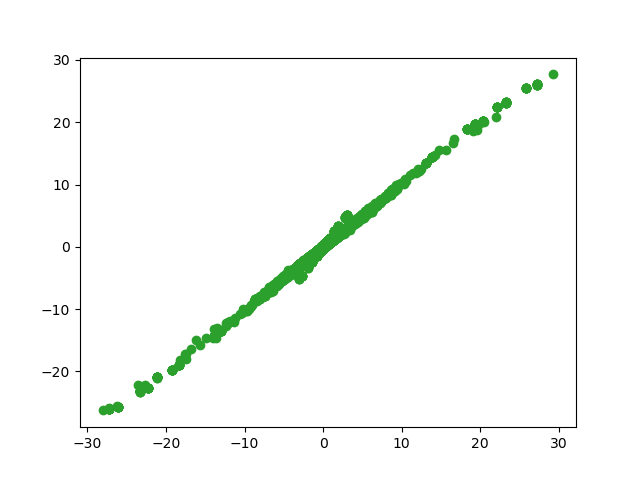

In [41]:
Natoms = []
y_baseline = []
for frame in frames:
    Natoms.append(len(frame))
    y_baseline.append(len(frame)*self_contributions[28]) 
Natoms = np.array(Natoms).reshape(-1)   
y_baseline = np.array(y_baseline).reshape(-1)   

y_pred = model.predict(frames, KNM[:len(frames)])
f_pred = -model.predict(frames, KNM[len(frames):], compute_gradients=True)

print_score((y_pred-y_baseline)/Natoms, (y-y_baseline)/Natoms)
print_score(f_pred.flatten(), f.flatten())
# plt.plot((y_pred-y_baseline)/Natoms, (y-y_baseline)/Natoms, 'o')
# plt.plot([-0.1,0.6],[-0.1,0.6])
# plt.show()
plt.plot(f[:,:].flatten(), f_pred[:,:].flatten(), 'o')
plt.show()

<IPython.core.display.Javascript object>


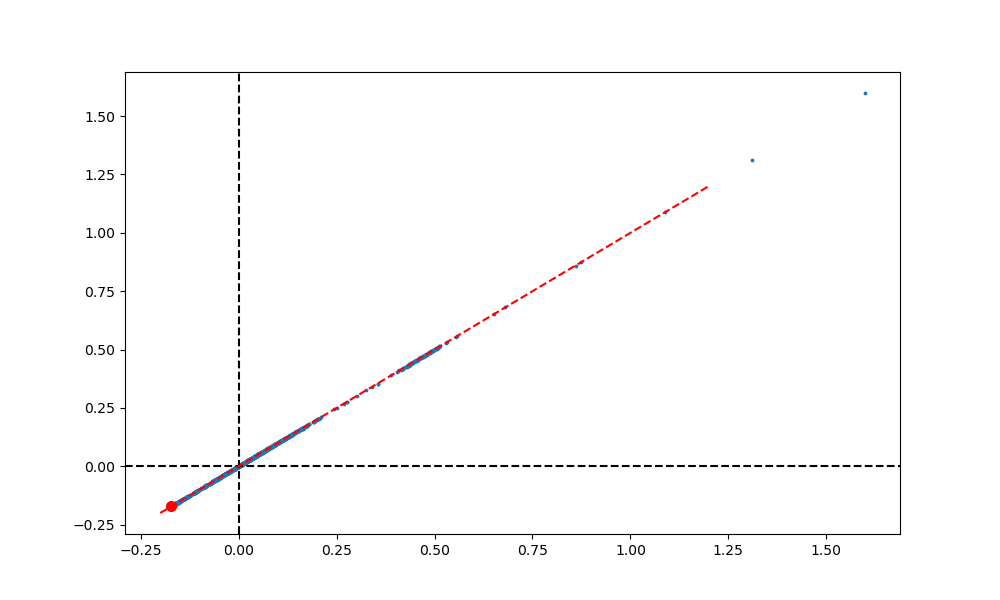

NGLWidget(max_frame=2199)

In [42]:
pos = np.hstack([((y_pred-y_baseline)/Natoms).reshape(-1,1), ((y-y_baseline)/Natoms).reshape(-1,1)])
_,ax,nglwg = interactive_scatter(frames, pos)
ax.plot([-0.2,1.2],[-0.2,1.2],'--r')
nglwg

# Run molecular dynamics on bulk Ni

In [16]:
from ase.md import MDLogger
from ase.md.langevin import Langevin
from ase import units,Atoms
from ase.io.trajectory import Trajectory
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.lattice.cubic import FaceCenteredCubic

In [17]:
from rascal.utils.io import load_obj
from rascal.models import KRR

from ase.calculators.calculator import Calculator,all_changes
from copy import deepcopy


class ASEMLCalculator(Calculator):
    """Wrapper class to use a rascal model as an interatomic potential in ASE

    Parameters
    ----------
    model : class
        a trained model of the rascal library that can predict the energy and
        derivaties of the energy w.r.t. atomic positions
    representation : class
        a representation calculator of rascal compatible with the trained model
    """

    implemented_properties = ['energy','forces']
    'Properties calculator can handle (energy, forces, ...)'

    default_parameters = {}
    'Default parameters'

    nolabel = True

    def __init__(self, model, representation, **kwargs):
        Calculator.__init__(self, **kwargs)

        self.model = model
        self.representation = representation

    def calculate(self, atoms=None, properties=['energy'],
                  system_changes=all_changes):
        Calculator.calculate(self, atoms, properties, system_changes)
        self.atoms.wrap(eps=1e-10)
        X = [self.atoms]
        managers = self.representation.transform(X)

        energy = self.model.predict(managers)
        forces = -self.model.predict(managers, compute_gradients=True)

        self.results['energy'] = energy
        self.results['free_energy'] = energy
        self.results['forces'] = forces


In [18]:
model_fn = '/home/musil/nickel_potential/models/radial_scaling/model_rc6_n12_l7_g0.4_gto_r02_exp3_z2_lmbe1e-03_lmbf5e-02.json'
model = load_obj(model_fn)
model.self_contributions = {int(k):v for k,v in model.self_contributions.items()}
calc = ASEMLCalculator(model, model.kernel._rep)

In [52]:
model.kernel._rep.hypers

{'max_radial': 12,
 'max_angular': 7,
 'soap_type': 'PowerSpectrum',
 'normalize': True,
 'inversion_symmetry': True,
 'expansion_by_species_method': 'structure wise',
 'global_species': [],
 'compute_gradients': True,
 'cutoff_function': {'type': 'RadialScaling',
  'cutoff': {'value': 6, 'unit': 'AA'},
  'smooth_width': {'value': 0.5, 'unit': 'AA'},
  'rate': {'value': 1, 'unit': 'AA'},
  'scale': {'value': 2, 'unit': 'AA'},
  'exponent': {'value': 3, 'unit': 'AA'}},
 'gaussian_density': {'type': 'Constant',
  'gaussian_sigma': {'value': 0.4, 'unit': 'AA'}},
 'radial_contribution': {'type': 'GTO',
  'optimization': {'type': 'Spline',
   'accuracy': 1e-08,
   'range': {'begin': 0, 'end': 6}}}}

In [54]:
model.kernel.to_dict()

{'version': '0.1',
 'class_name': 'Kernel',
 'module_name': 'rascal.models.kernels',
 'init_params': {'representation': {'version': '0.1',
   'class_name': 'SphericalInvariants',
   'module_name': 'rascal.representations.spherical_invariants',
   'init_params': {'interaction_cutoff': 6,
    'cutoff_smooth_width': 0.5,
    'max_radial': 12,
    'max_angular': 7,
    'soap_type': 'PowerSpectrum',
    'inversion_symmetry': True,
    'normalize': True,
    'expansion_by_species_method': 'structure wise',
    'global_species': [],
    'compute_gradients': True,
    'gaussian_sigma_type': 'Constant',
    'gaussian_sigma_constant': 0.4,
    'cutoff_function_type': 'RadialScaling',
    'radial_basis': 'GTO',
    'optimization_args': {'accuracy': 1e-08, 'type': 'Spline'},
    'cutoff_function_parameters': {'exponent': 3, 'rate': 1, 'scale': 2}},
   'data': {}},
  'name': 'GAP',
  'kernel_type': 'Sparse',
  'target_type': 'Structure',
  'zeta': 2},
 'data': {}}

In [24]:
%%time
log_fn = 'md.log'
filename = 'md.traj'

T = 400
time_step = 0.5 * units.fs
length = 10 * units.fs
n_step = int(length/time_step)
print(f'doing Nsteps: {n_step}')

aNi_gap = 3.514882399228899
atoms = Atoms(FaceCenteredCubic(directions=[[0,0,1], [0,-1,0], [1,0,0]],size=(3,3,3), 
                                symbol='Ni', pbc=(1,1,1), latticeconstant=aNi_gap))

MaxwellBoltzmannDistribution(atoms, T* units.kB)

atoms.set_calculator(calc)

traj = Trajectory(filename, mode='w', atoms=atoms, master=None)

dyn = Langevin(atoms, time_step, units.kB * T, 0.002, trajectory=traj)

# dyn.attach(MDLogger(dyn, atoms, log_fn, header=True, stress=False,
#            peratom=False, mode="w"), interval=50)

dyn.attach(traj.write, interval=100)

dyn.run(n_step)

doing Nsteps: 20
CPU times: user 5min 15s, sys: 10.6 s, total: 5min 25s
Wall time: 3min 37s


True

In [25]:
(5*60+15) / len(traj) / len(atoms)

0.13257575757575757

In [26]:
(35*60+12) / 2000 / len(atoms)

0.009777777777777778

In [23]:
len(atoms)

108

In [30]:
atoms.wrap(eps=1e-10)

In [33]:
%%timeit -n 3
managers = model.kernel._rep.transform([atoms])

932 ms ± 22.7 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)


In [34]:
0.932 / len(atoms)

0.00862962962962963

In [44]:
managers = model.kernel._rep.transform([atoms])

In [45]:
%%timeit -n 3
model._preprocess_input(managers)

19.8 ms ± 948 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)


In [47]:
%%timeit -n 3
y_pred = model.predict(managers)

19.1 ms ± 400 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)


In [46]:
%%timeit -n 3
model._preprocess_input(managers, compute_gradients=True)

4.86 s ± 43.3 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)


In [48]:
KNM,Y0 = model._preprocess_input(managers, compute_gradients=True)

In [51]:
%%timeit -n 3
np.dot(KNM, model.weights)

The slowest run took 18.64 times longer than the fastest. This could mean that an intermediate result is being cached.
66.2 µs ± 115 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)


In [37]:
%%timeit -n 3
y_pred = model.predict(managers)
f_pred = -model.predict(managers, compute_gradients=True)

4.47 s ± 35.8 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)


In [38]:
4.47 / len(atoms)

0.041388888888888885

In [39]:
0.04138 + 0.00862

0.05

In [40]:
%%timeit -n 3
calc.calculate(atoms, ['energy', 'forces'])

5.31 s ± 38.4 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)


In [41]:
5.31 / len(atoms)

0.049166666666666664

# Test the model on dimer configurations

In [31]:
soap = kernel._rep

In [32]:
#creating atoms pairs, H is 1, C is 6 and O is 8, the first atom is the origin one
pairs = [[28,28]]
ndists = 40 #number of distances to look at
dists = np.linspace(0.1,4.9,ndists) #distance list, can be changed 
print('Number of configurations: ', len(pairs)*len(dists))

Number of configurations:  40


In [33]:
frames = []
for p in pairs:
    for d in dists:
        #using ase we can create the cell and place the atoms
        atoms = ase.Atoms(numbers=p,pbc=False,cell=np.eye(3)*10,positions=[[0,0,0],[d,0,0]])
        frames.append(atoms)
X = soap.transform(frames)
KNM = kernel(X, X_pseudo)
e_pairs = model.predict(frames,KNM)
e_pairs -= e_pairs.mean()

<IPython.core.display.Javascript object>


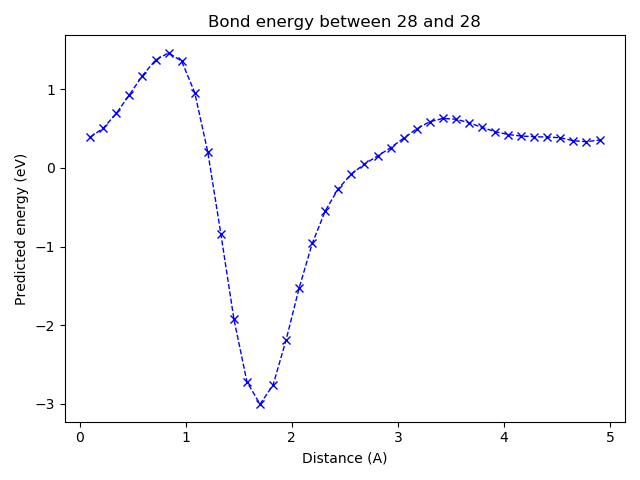

In [34]:
for pair_to_plot in pairs:
    i = pairs.index(pair_to_plot)

    fig, ax = plt.subplots()
    ax.plot(dists,e_pairs[i*ndists:(i+1)*ndists],'--xb',linewidth=1)
    # ax.plot(dists,f_pairs[i*ndists:(i+1)*ndists],'--xr',linewidth=1)
    ax.set_xlabel('Distance (A)')
    ax.set_ylabel('Predicted energy (eV)')
    ax.set_title('Bond energy between {} and {}'.format(*pair_to_plot))
    plt.tight_layout()
    plt.show()